In [2]:
!pip install kmodes
!pip install scikeras
!pip install tensorflow
!pip install prince


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle


from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor # Import KerasRegressor from scikeras
from tensorflow.keras.callbacks import EarlyStopping

RANDOM_STATE = 42

In [3]:
df=pd.read_excel('/content/Preprocessed.xlsx')

# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

# Calculate correlation on the numeric DataFrame
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
(correlation_matrix)


import matplotlib.pyplot as plt
import seaborn as sns

# # Set figure size
# plt.figure(figsize=(12, 8))

# # Create a heatmap for the correlation matrix
# sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

# # Set title
# plt.title('Correlation Matrix Heatmap')

# # Show plot
# #plt.show()


In [4]:

# Function to extract time features
def extract_time_features(df, column):
    df[f"{column}_year"] = df[column].dt.year
    df[f"{column}_month"] = df[column].dt.month
    df[f"{column}_day"] = df[column].dt.day
    df[f"{column}_weekday"] = df[column].dt.weekday  # 0 = Monday, 6 = Sunday
    df[f"{column}_weekofyear"] = df[column].dt.isocalendar().week
    return df

# Apply function to each datetime column
for col in ["Expected_checkin", "Expected_checkout", "Booking_date"]:
    df = extract_time_features(df, col)

# Function to calculate stays in weekend and weekdays
def calculate_weekend_weekdays(row):
    weekends = 0
    weekdays = 0
    checkin_date = row["Expected_checkin"]

    for i in range(row["Duration_checkin_checkout"]):
        day = (checkin_date + pd.Timedelta(days=i)).weekday()  # 0=Monday, 6=Sunday
        if day in [4, 5]:  # Friday (4) and Saturday (5) are weekends
            weekends += 1
        else:
            weekdays += 1

    return pd.Series([weekends, weekdays])

# Apply function to create new columns
df[["stays_in_weekend", "stays_in_week"]] = df.apply(calculate_weekend_weekdays, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27499 entries, 0 to 27498
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Reservation_ID                27499 non-null  int64         
 1   Gender                        27499 non-null  object        
 2   Age                           27499 non-null  int64         
 3   Ethnicity                     27499 non-null  object        
 4   Educational_Level             27499 non-null  object        
 5   Income                        27499 non-null  object        
 6   Country_region                27499 non-null  object        
 7   Hotel_Type                    27499 non-null  object        
 8   Expected_checkin              27499 non-null  datetime64[ns]
 9   Expected_checkout             27499 non-null  datetime64[ns]
 10  Booking_date                  27499 non-null  datetime64[ns]
 11  Adults                      

In [5]:
df['Reservation_Status'].value_counts()

,count
Reservation_Status,
check-out,21240
canceled,4134
no-show,2125


In [6]:
df.describe()

,Reservation_ID,Age,Expected_checkin,Expected_checkout,Booking_date,Adults,Children,Babies,Discount_Rate,Room_Rate,...,Expected_checkout_day,Expected_checkout_weekday,Expected_checkout_weekofyear,Booking_date_year,Booking_date_month,Booking_date_day,Booking_date_weekday,Booking_date_weekofyear,stays_in_weekend,stays_in_week
count,2.749900e+04,27499.000000,27499,27499,27499,27499.000000,27499.000000,27499.000000,27499.000000,27499.000000,...,27499.000000,27499.000000,27499.0,27499.000000,27499.000000,27499.000000,27499.000000,27499.0,27499.000000,27499.000000
mean,5.016461e+07,43.977454,2016-04-18 17:56:47.556638208,2016-04-20 14:00:56.292956160,2015-12-30 20:05:05.291101696,2.232118,1.743882,0.309466,8.293029,155.645134,...,15.878505,2.963017,25.696025,2015.481363,6.707117,15.987490,2.994945,27.772719,0.501509,1.334703
min,3.154000e+03,18.000000,2014-11-18 00:00:00,2014-11-22 00:00:00,2014-01-09 00:00:00,1.000000,1.000000,0.000000,0.000000,100.000000,...,1.000000,0.000000,1.0,2014.000000,1.000000,1.000000,0.000000,1.0,0.000000,0.000000
25%,2.523943e+07,31.000000,2015-11-18 00:00:00,2015-11-20 00:00:00,2015-08-07 00:00:00,1.000000,1.000000,0.000000,0.000000,124.000000,...,8.000000,1.000000,13.0,2015.000000,4.000000,8.000000,1.000000,15.0,0.000000,1.000000
50%,5.014996e+07,44.000000,2016-04-03 00:00:00,2016-04-05 00:00:00,2015-11-22 00:00:00,2.000000,2.000000,0.000000,5.000000,149.453032,...,16.000000,3.000000,26.0,2015.000000,7.000000,16.000000,3.000000,29.0,0.000000,1.000000
75%,7.518288e+07,57.000000,2016-08-13 00:00:00,2016-08-15 00:00:00,2016-05-08 00:00:00,3.000000,2.000000,0.000000,10.000000,181.000000,...,23.000000,5.000000,37.0,2016.000000,10.000000,23.000000,5.000000,41.0,1.000000,2.000000
max,9.999900e+07,70.000000,2017-09-06 00:00:00,2017-09-09 00:00:00,2017-08-30 00:00:00,5.000000,3.000000,2.000000,30.000000,250.000000,...,31.000000,6.000000,53.0,2017.000000,12.000000,31.000000,6.000000,53.0,2.000000,4.000000
std,2.886911e+07,15.303148,NaN,NaN,NaN,1.180172,0.721972,0.579941,7.841725,38.314829,...,8.775510,1.950301,14.625012,0.642609,3.447829,8.762348,2.013612,15.186339,0.704832,0.940661


In [7]:
df.columns

Index(['Reservation_ID', 'Gender', 'Age', 'Ethnicity', 'Educational_Level',
       'Income', 'Country_region', 'Hotel_Type', 'Expected_checkin',
       'Expected_checkout', 'Booking_date', 'Adults', 'Children', 'Babies',
       'Meal_Type', 'Visted_Previously', 'Previous_Cancellations',
       'Deposit_type', 'Booking_channel', 'Required_Car_Parking',
       'Reservation_Status', 'Use_Promotion', 'Discount_Rate', 'Room_Rate',
       'Duration_checkin_checkout', 'Booking_to_checkin_duration',
       'No_of_ppl_without_babies', 'No_of_ppl_with_babies', 'No_of_Rooms',
       'Revenue', 'Revenue_with_disc', 'Expected_checkin_year',
       'Expected_checkin_month', 'Expected_checkin_day',
       'Expected_checkin_weekday', 'Expected_checkin_weekofyear',
       'Expected_checkout_year', 'Expected_checkout_month',
       'Expected_checkout_day', 'Expected_checkout_weekday',
       'Expected_checkout_weekofyear', 'Booking_date_year',
       'Booking_date_month', 'Booking_date_day', 'Booking_da

## negative leadtime

In [8]:
duration=df[df['Booking_to_checkin_duration']<0]
duration

,Reservation_ID,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,...,Expected_checkout_day,Expected_checkout_weekday,Expected_checkout_weekofyear,Booking_date_year,Booking_date_month,Booking_date_day,Booking_date_weekday,Booking_date_weekofyear,stays_in_weekend,stays_in_week
665,23219836,M,45,caucasian,High-School,25K --50K,South,City Hotel,2015-01-21,2015-01-24,...,24,5,4,2015,1,22,3,4,1,2
1310,76350282,M,64,Latino,College,>100K,North,City Hotel,2015-03-03,2015-03-05,...,5,3,10,2015,3,5,3,10,0,2
1824,92103951,M,52,caucasian,High-School,25K --50K,East,Airport Hotels,2015-04-02,2015-04-03,...,3,4,14,2015,4,3,4,14,0,1
4035,22318084,M,48,Latino,College,25K --50K,South,City Hotel,2015-06-09,2015-06-13,...,13,5,24,2015,6,10,2,24,1,3
5097,14142898,F,55,African American,College,<25K,East,Airport Hotels,2015-07-02,2015-07-03,...,3,4,27,2015,7,3,4,27,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27469,63436578,M,32,caucasian,Grad,50K -- 100K,West,City Hotel,2017-07-15,2017-07-17,...,17,0,29,2017,7,16,6,28,1,1
27473,86746518,M,70,Latino,High-School,<25K,South,City Hotel,2017-07-17,2017-07-19,...,19,2,29,2017,7,18,1,29,0,2
27479,8661274,F,48,Asian American,Grad,>100K,South,Resort,2017-07-25,2017-07-27,...,27,3,30,2017,7,26,2,30,0,2
27493,13299919,M,27,caucasian,High-School,>100K,West,City Hotel,2017-08-12,2017-08-16,...,16,2,33,2017,8,13,6,32,1,3


In [9]:
duration['Booking_to_checkin_duration'].value_counts()

,count
Booking_to_checkin_duration,
-1,274
-2,132
-3,77
-4,23


In [10]:
duration.groupby('Booking_to_checkin_duration')['Use_Promotion'].value_counts()

Booking_to_checkin_duration  Use_Promotion
-4                           Yes               18
                             No                 5
-3                           Yes               52
                             No                25
-2                           Yes               94
                             No                38
-1                           Yes              188
                             No                86
Name: count, dtype: int64

In [11]:
df.loc[df["Booking_to_checkin_duration"] < 0, "Expected_checkin"] = df["Booking_date"]

# Recalculate duration after correction
df["Booking_to_checkin_duration"] = (df["Expected_checkin"] - df["Booking_date"]).dt.days
# Calculating revenue
df['Revenue'] = df['Room_Rate'] * df['Duration_checkin_checkout'] * df['No_of_Rooms']
df['Revenue_with_disc'] = df['Revenue'] * (100 - (df['Discount_Rate'])) / 100

    # Log-transformed revenue
df['Revenue_with_disc_log'] = np.log(df['Revenue_with_disc'] + 1)

# Check if any negative values remain
(df[df["Booking_to_checkin_duration"] < 0])

,Reservation_ID,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,...,Expected_checkout_weekday,Expected_checkout_weekofyear,Booking_date_year,Booking_date_month,Booking_date_day,Booking_date_weekday,Booking_date_weekofyear,stays_in_weekend,stays_in_week,Revenue_with_disc_log


## Cancelled


In [12]:
df['Reservation_Status_numeric'] = df['Reservation_Status'].map({'check-out': 1, 'canceled': 2, 'no-show': 3})
df_cancelled=df[df['Reservation_Status']=='canceled']
df_ns=df[df['Reservation_Status']=='no-show']
df_cn=df[df['Reservation_Status']!='check-out']
df_cn

,Reservation_ID,Gender,Age,Ethnicity,Educational_Level,Income,Country_region,Hotel_Type,Expected_checkin,Expected_checkout,...,Expected_checkout_weekofyear,Booking_date_year,Booking_date_month,Booking_date_day,Booking_date_weekday,Booking_date_weekofyear,stays_in_weekend,stays_in_week,Revenue_with_disc_log,Reservation_Status_numeric
35,30315054,M,43,caucasian,College,25K --50K,West,City Hotel,2015-01-21,2015-01-24,...,4,2014,6,16,0,25,1,2,5.938482,2
37,99680704,F,56,African American,High-School,<25K,North,Airport Hotels,2015-01-21,2015-01-23,...,4,2014,6,17,1,25,0,2,5.913806,2
41,7947809,F,51,African American,Grad,50K -- 100K,East,Airport Hotels,2015-01-21,2015-01-22,...,4,2014,6,24,1,26,0,1,5.153763,3
42,21794447,M,25,caucasian,High-School,25K --50K,South,City Hotel,2015-01-30,2015-01-31,...,5,2014,6,25,2,26,1,0,4.797849,3
43,58372374,M,50,Latino,High-School,50K -- 100K,South,City Hotel,2015-01-21,2015-01-23,...,4,2014,6,27,4,26,0,2,5.622498,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27490,79241182,F,29,caucasian,College,50K -- 100K,East,City Hotel,2017-08-31,2017-09-04,...,36,2017,8,7,0,32,2,2,6.166479,2
27491,29477447,F,49,caucasian,Grad,>100K,East,City Hotel,2017-08-13,2017-08-15,...,33,2017,8,8,1,32,0,2,6.500894,2
27494,11367837,F,64,African American,College,25K --50K,West,Airport Hotels,2017-08-13,2017-08-16,...,33,2017,8,13,6,32,0,3,5.947130,2
27495,93051344,M,64,caucasian,Grad,25K --50K,South,Airport Hotels,2017-08-15,2017-08-16,...,33,2017,8,13,6,32,0,1,4.933471,3


                              is_canceled
is_canceled                      1.000000
Reservation_Status_numeric       0.482986
Expected_checkin_weekday         0.043594
Expected_checkin_day             0.008924
Reservation_ID                   0.008846
Children                         0.007300
Age                              0.004942
No_of_ppl_without_babies         0.003748
No_of_ppl_with_babies            0.002086
stays_in_week                    0.001010
Duration_checkin_checkout        0.000217
Adults                          -0.000049
Revenue_with_disc               -0.000785
stays_in_weekend                -0.001045
Revenue_with_disc_log           -0.001674
No_of_Rooms                     -0.001861
Revenue                         -0.002879
Babies                          -0.003567
Booking_date_year               -0.004426
Booking_date_weekday            -0.004755
Booking_to_checkin_duration     -0.004810
Expected_checkout_day           -0.006223
Expected_checkout_weekday       -0

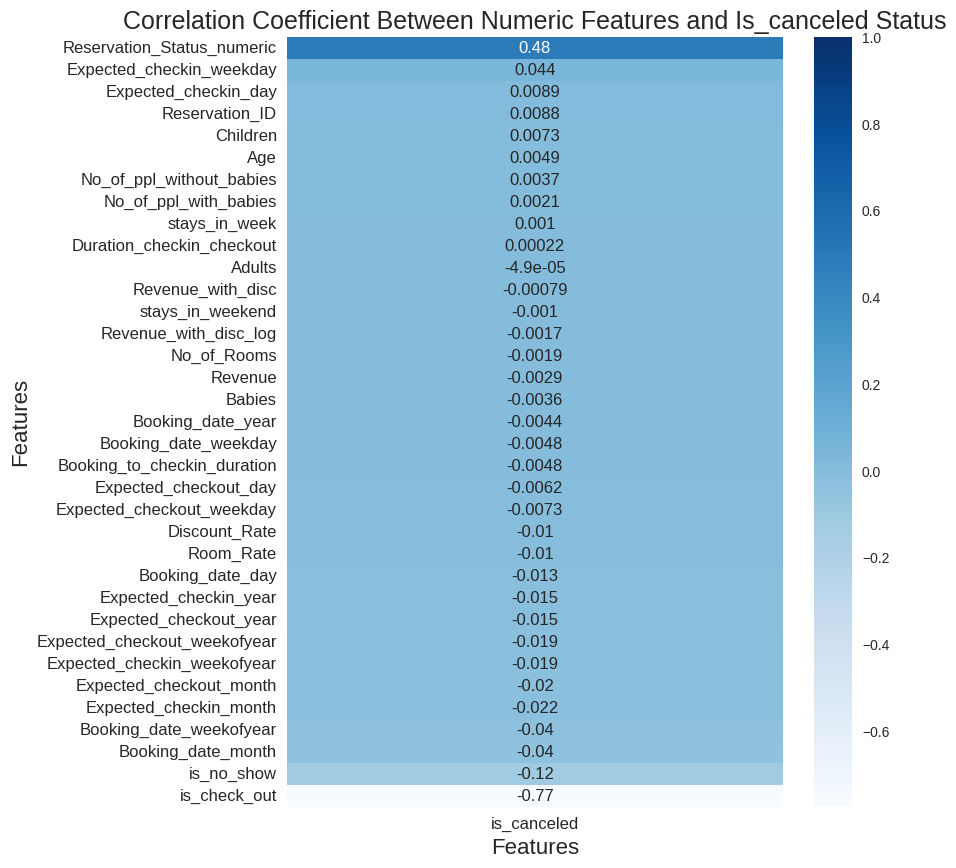

                              is_no_show
is_no_show                      1.000000
Reservation_Status_numeric      0.810324
Expected_checkin_weekday        0.030599
Booking_date_day                0.014261
Booking_date_weekday            0.009451
Babies                          0.008779
Expected_checkin_day            0.006974
Booking_date_year               0.005108
Children                        0.003254
No_of_ppl_with_babies           0.002566
stays_in_weekend                0.001989
Reservation_ID                 -0.000567
No_of_Rooms                    -0.000729
No_of_ppl_without_babies       -0.000881
Expected_checkout_month        -0.001093
Expected_checkin_weekofyear    -0.001749
Expected_checkout_day          -0.002170
Expected_checkout_weekofyear   -0.002524
Age                            -0.002679
Discount_Rate                  -0.002912
Adults                         -0.003029
Booking_to_checkin_duration    -0.003070
Expected_checkin_month         -0.003237
Duration_checkin

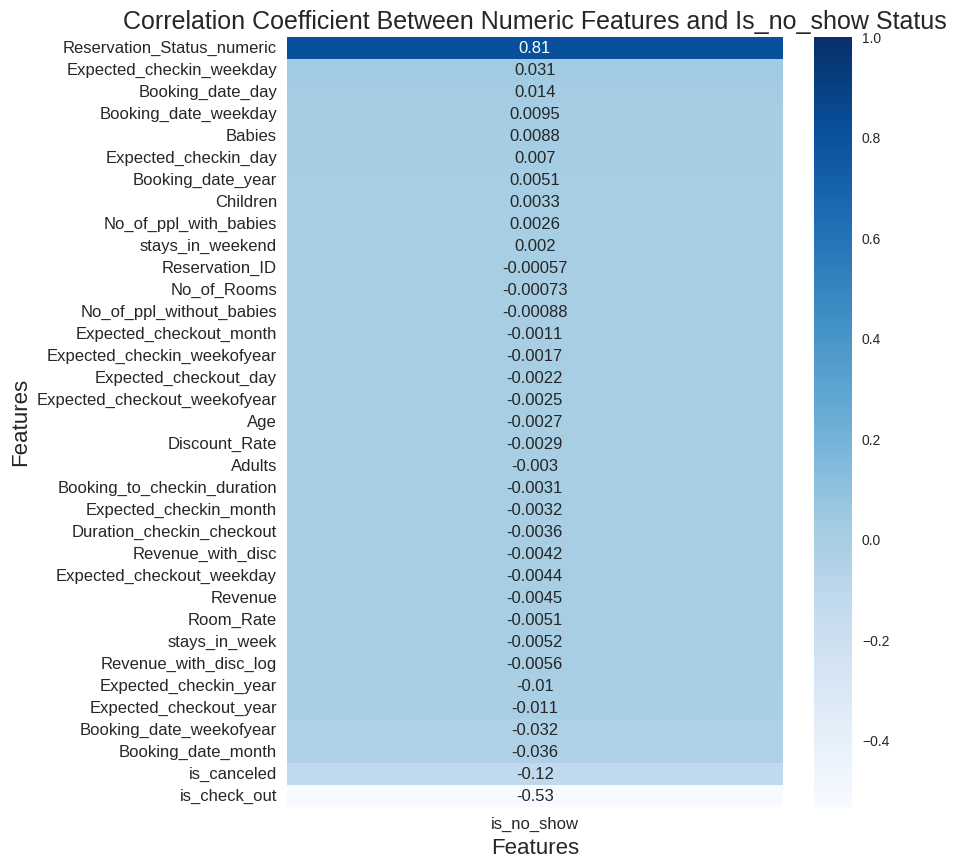

                              is_check_out
is_check_out                      1.000000
Booking_date_month                0.057149
Booking_date_weekofyear           0.054276
Expected_checkin_month            0.020608
Expected_checkout_year            0.019923
Expected_checkin_year             0.019490
Expected_checkout_weekofyear      0.018084
Expected_checkout_month           0.018077
Expected_checkin_weekofyear       0.017684
Room_Rate                         0.012091
Discount_Rate                     0.010519
Expected_checkout_weekday         0.009051
Expected_checkout_day             0.006687
Booking_to_checkin_duration       0.006055
Revenue                           0.005330
Revenue_with_disc_log             0.004987
Revenue_with_disc                 0.003324
stays_in_week                     0.002481
Booking_date_day                  0.002274
Duration_checkin_checkout         0.002100
No_of_Rooms                       0.002050
Adults                            0.001971
Booking_dat

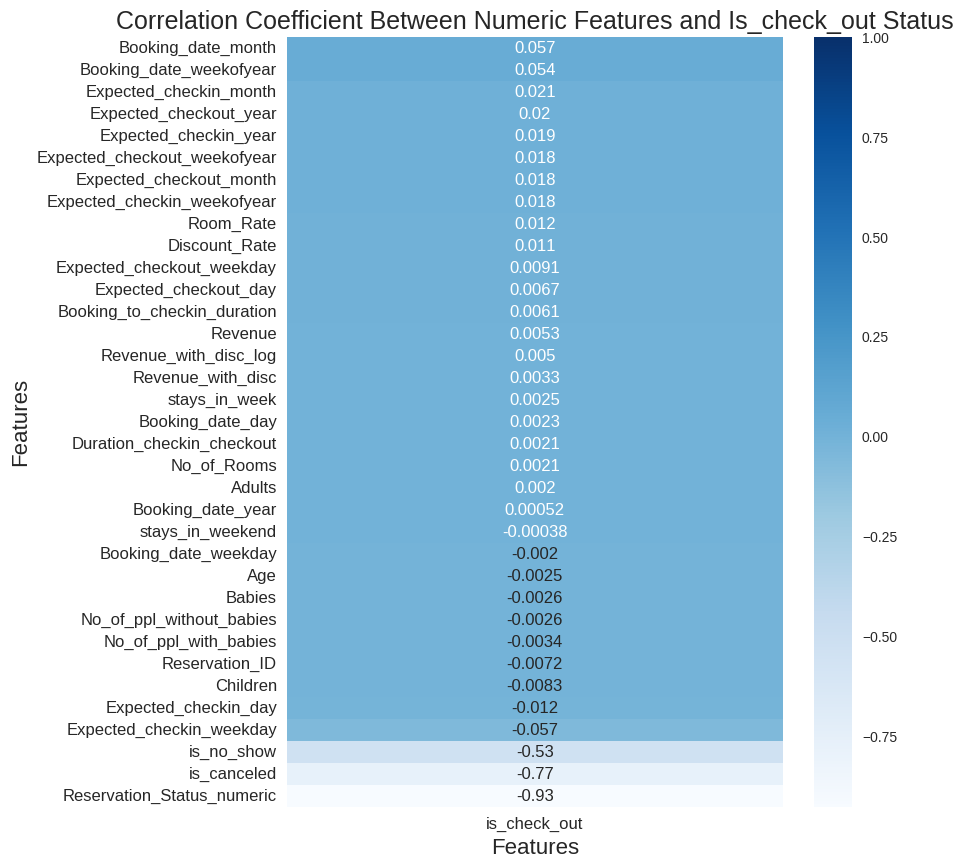

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create binary columns for each target variable
df['is_canceled'] = (df['Reservation_Status'] == 'canceled').astype(int)
df['is_no_show'] = (df['Reservation_Status'] == 'no-show').astype(int)
df['is_check_out'] = (df['Reservation_Status'] == 'check-out').astype(int)

# Select only numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

# Function to visualize correlation between numeric features and target columns
def plot_target_corr(df, target_column, numeric_columns):
    fig = plt.figure(figsize=(8, 10))
    print(df[numeric_columns].corr()[[target_column]].sort_values(target_column, ascending=False),)
    # Calculate correlation with target column and sort features by correlation
    ax = sns.heatmap(df[numeric_columns].corr()[[target_column]].sort_values(target_column, ascending=False),
                     annot=True,
                     annot_kws={"size": 12},
                     cmap='Blues')

    ax.set_title(f'Correlation Coefficient Between Numeric Features and {target_column.capitalize()} Status', fontsize=18)
    ax.set_xlabel('Features', fontsize=16)
    ax.set_ylabel('Features', fontsize=16)
    ax.tick_params(axis="both", labelsize=12)

    # Adjust y-axis limits to make sure the title is visible
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(top=y_max + 1)

    # Show plot
    plt.show()

# Plot correlation for each target variable (only numeric columns)
plot_target_corr(df, 'is_canceled', numeric_columns)
plot_target_corr(df, 'is_no_show', numeric_columns)
plot_target_corr(df, 'is_check_out', numeric_columns)


<ipython-input-14-46c944ac5436>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['is_canceled'].unique(), y=df['is_canceled'].value_counts(normalize=True), palette=['teal', 'lightblue'])


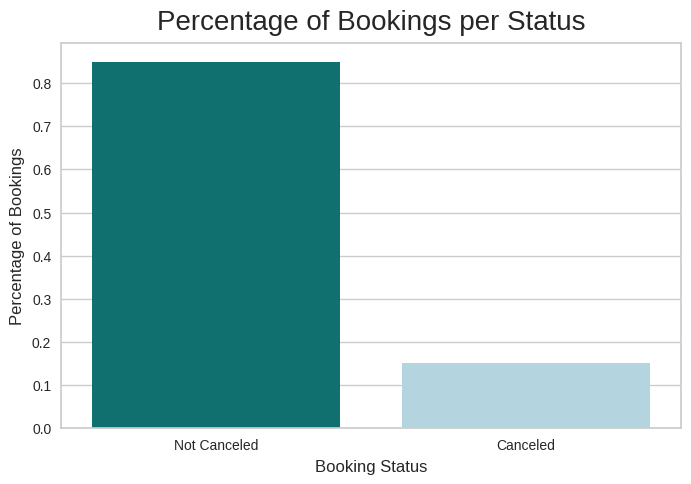

In [14]:
# Visualizing the percentage of canceled vs not canceled bookings:
plt.figure(figsize=(8,5))
plt.title("Percentage of Bookings per Status", fontsize = 20, pad = 10)
sns.barplot(x=df['is_canceled'].unique(), y=df['is_canceled'].value_counts(normalize=True), palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Bookings", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

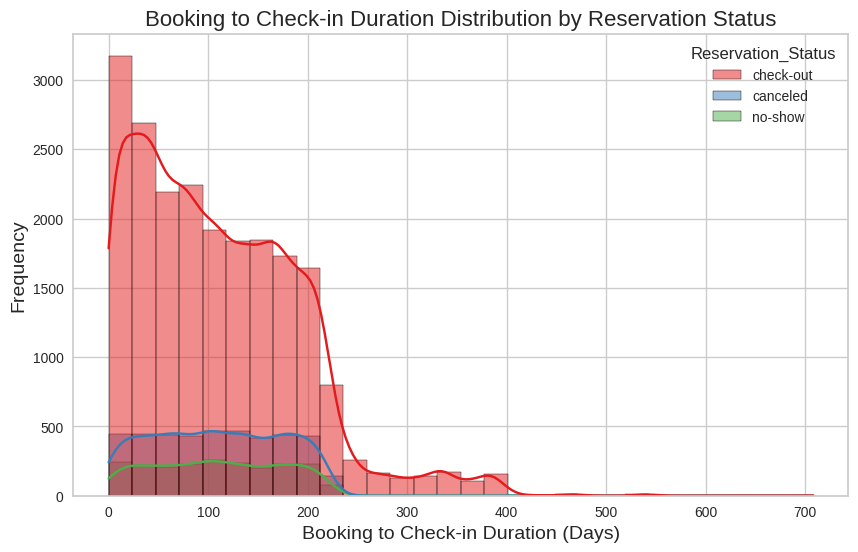

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Booking_to_checkin_duration', hue='Reservation_Status', kde=True, bins=30, palette='Set1')

# Set plot title and labels
plt.title('Booking to Check-in Duration Distribution by Reservation Status', fontsize=16)
plt.xlabel('Booking to Check-in Duration (Days)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show plot
plt.show()


In [16]:
# Calculate average lead time (Booking_to_checkin_duration) for canceled vs. non-canceled bookings
avg_lead_time = df.groupby('is_canceled')['Booking_to_checkin_duration'].mean()

# Display the result
print("Average Lead Time for Canceled and Non-Canceled Bookings:")
print(avg_lead_time)

Average Lead Time for Canceled and Non-Canceled Bookings:
is_canceled
0    110.100021
1    109.050314
Name: Booking_to_checkin_duration, dtype: float64


<ipython-input-17-63b4dbce2445>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  canceled = canceled.resample('M').sum()
<ipython-input-17-63b4dbce2445>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  not_canceled = not_canceled.resample('M').sum()


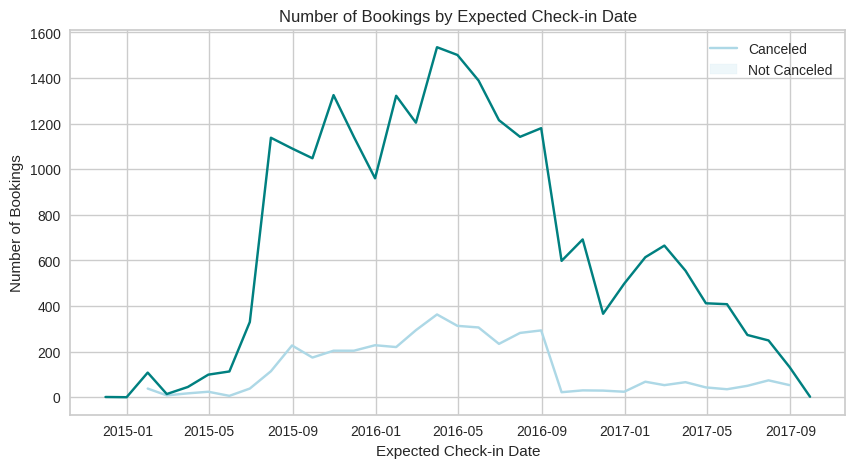

In [17]:
# Created a dataframe of canceled bookings for plotting purposes based on Expected_checkin
canceled = df[df['is_canceled'] == 1][['Expected_checkin']]
canceled.set_index('Expected_checkin', inplace=True)
canceled['count'] = 1
canceled = canceled.resample('M').sum()

# Created a dataframe of not canceled bookings for plotting purposes based on Expected_checkin
not_canceled = df[df['is_canceled'] == 0][['Expected_checkin']]
not_canceled.set_index('Expected_checkin', inplace=True)
not_canceled['count'] = 1
not_canceled = not_canceled.resample('M').sum()

# Visualizing the number of canceled and not canceled bookings by expected check-in date:
plt.figure(figsize=(10,5))
sns.lineplot(x=canceled.index, y=canceled['count'], color='lightblue')
sns.lineplot(x=not_canceled.index, y=not_canceled['count'], color='teal')
plt.ylabel('Number of Bookings')
plt.xlabel('Expected Check-in Date')
plt.title('Number of Bookings by Expected Check-in Date')
plt.legend(['Canceled', 'Not Canceled'])
plt.show()


<ipython-input-18-ba2bf7f5b556>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['is_canceled'], y=df['Duration_checkin_checkout'], palette=['teal', 'lightblue'])


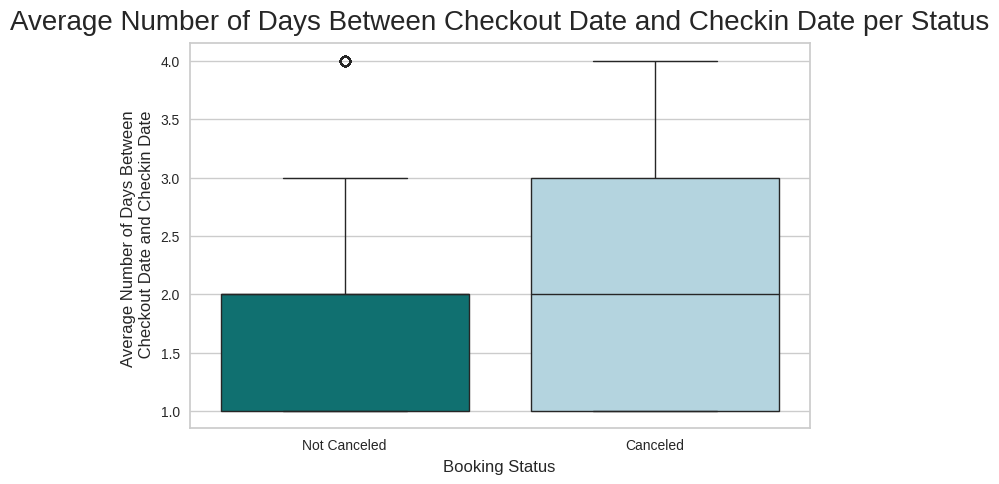

In [18]:
# Visualizing the average number of days between status date and arrival date for canceled and not canceled bookings:
plt.figure(figsize=(8,5))
plt.title("Average Number of Days Between Checkout Date and Checkin Date per Status", fontsize = 20, pad = 10)
sns.boxplot(x=df['is_canceled'], y=df['Duration_checkin_checkout'], palette=['teal', 'lightblue'])
plt.xlabel("Booking Status", fontsize = 12, labelpad = 5)
plt.ylabel("Average Number of Days Between \n Checkout Date and Checkin Date", fontsize = 12, labelpad = 5)
plt.xticks(ticks=[0, 1], labels=['Not Canceled', 'Canceled']);

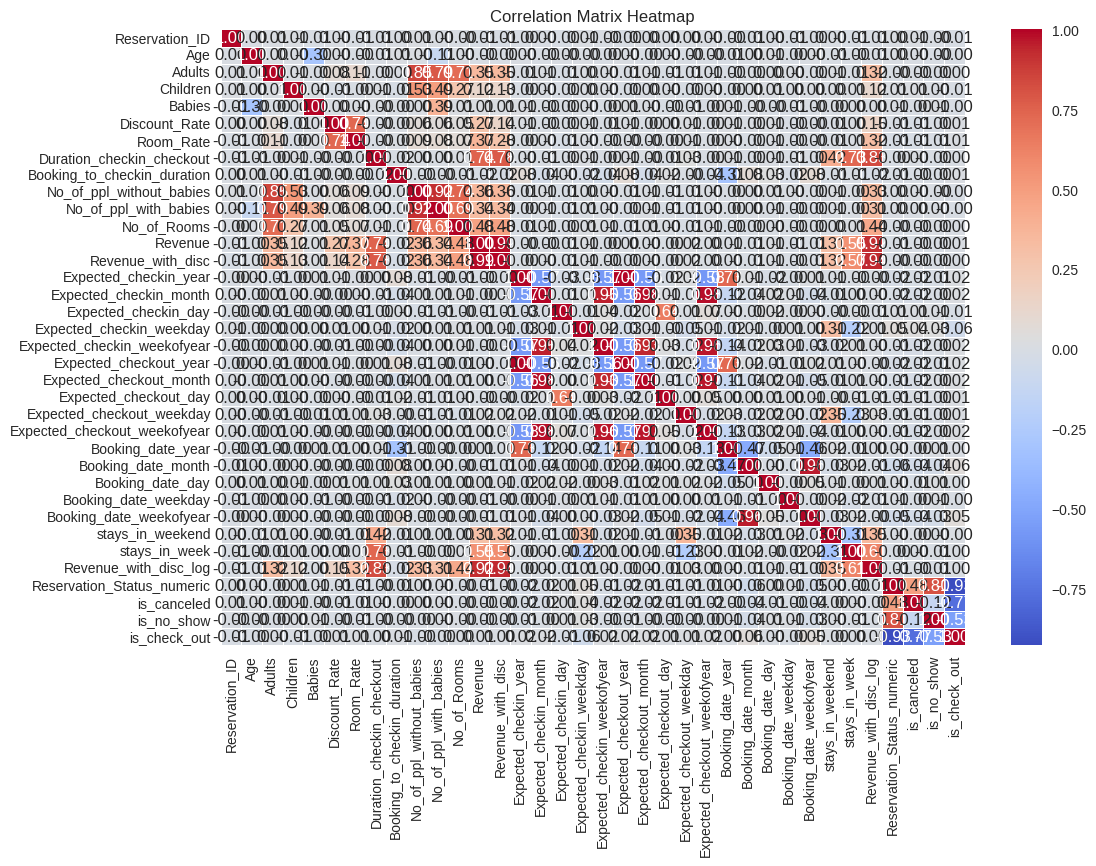

In [19]:
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

# Calculate correlation on the numeric DataFrame
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
(correlation_matrix)


import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 8))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

# Set title
plt.title('Correlation Matrix Heatmap')

# Show plot
plt.show()


## Clustering

## final-PCA reduction visualized by tsne

In [20]:
df_canceled = df[df['is_canceled'] == 1]

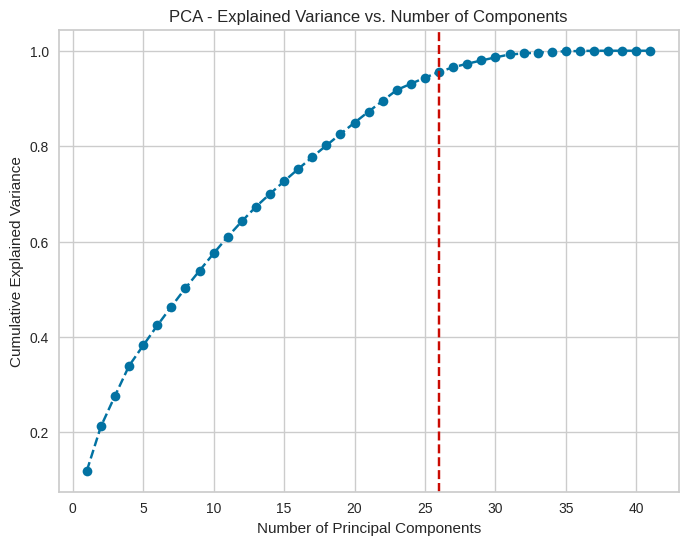

Optimal number of components to retain 95% variance: 26
Cumulative explained variance: 0.9556513324511031


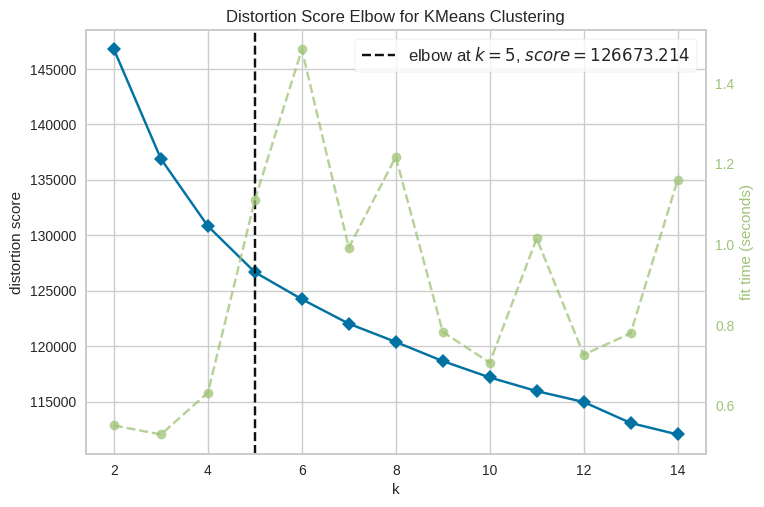

<ipython-input-21-2abd80b89cbb>:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_kmeans'] = km_model.labels_


KMeans Silhouette Score: 0.08801006830369966
KMeans Calinski-Harabasz Index: 287.6891171245136
KMeans Davies-Bouldin Index: 2.6399935102164953


<ipython-input-21-2abd80b89cbb>:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_dbscan'] = dbscan_labels


DBSCAN Silhouette Score: None
DBSCAN Calinski-Harabasz Index: None
DBSCAN Davies-Bouldin Index: None


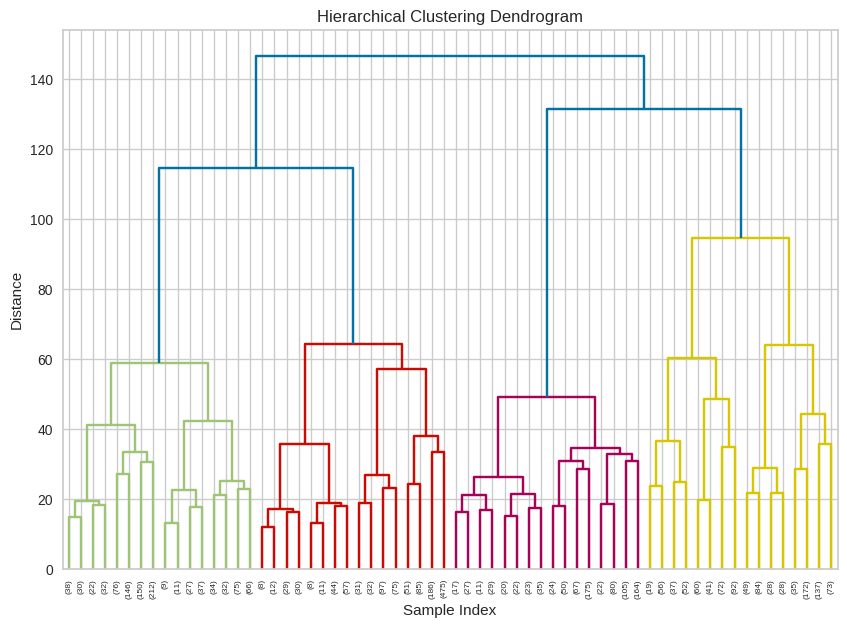

Enter the number of clusters based on the dendrogram: 5


<ipython-input-21-2abd80b89cbb>:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_agglo'] = agglo_labels


Agglomerative Clustering Silhouette Score: 0.06615345347929674
Agglomerative Clustering Calinski-Harabasz Index: 239.01580151458546
Agglomerative Clustering Davies-Bouldin Index: 2.963297791659511


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [21]:
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import pandas as pd

def clustering_pipeline_with_visualization(df, cols_to_drop, visualization_method='umap'):
    """
    Perform clustering on PCA-reduced data and visualize using t-SNE or UMAP.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        cols_to_drop (list): List of columns to drop from the DataFrame.
        visualization_method (str): Method for visualization ('umap' or 'tsne').

    Returns:
        pd.DataFrame: The original DataFrame with additional cluster columns.
    """
    # Drop unnecessary columns
    X = df.drop(columns=cols_to_drop)

    # Define ordinal mappings
    educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
    income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
    deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

    # Apply ordinal encoding
    X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
    X['Income'] = X['Income'].map(income_mapping)
    X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

    # Columns to apply one-hot encoding to
    categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                           'Previous_Cancellations', 'Required_Car_Parking']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

    # Apply one-hot encoding to categorical columns
    encoded_features = encoder.fit_transform(X[categorical_columns])

    # Convert encoded features to DataFrame with appropriate column names
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df = encoded_df.astype(int)

    # Reset indices of both DataFrames to ensure alignment
    X = X.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    # Concatenate encoded columns back to original DataFrame
    X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

    # Select only numerical columns
    numerical_df = X.select_dtypes(include=['number'])

    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_df)

    # Fit PCA
    pca = PCA()
    pca.fit(scaled_data)

    # Calculate cumulative explained variance ratio
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components that retain 95% of the variance
    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

    # Apply PCA with the selected number of components
    pca = PCA(n_components=optimal_components)
    pca_data = pca.fit_transform(scaled_data)

    # Plot the cumulative explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b', linestyle='--')
    plt.axvline(x=optimal_components, color='r', linestyle='--')
    plt.title('PCA - Explained Variance vs. Number of Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # Output the number of components selected and the variance explained
    print(f"Optimal number of components to retain 95% variance: {optimal_components}")
    print(f"Cumulative explained variance: {cumulative_variance[optimal_components - 1]}")

    # Use KElbowVisualizer to find optimal K
    km_model = KMeans(random_state=42, n_init=10)
    visualizer = KElbowVisualizer(km_model, k=(2, 15))
    visualizer.fit(pca_data)
    visualizer.show()

    # Get optimal K
    optimal_k = visualizer.elbow_value_

    # Refit KMeans with optimal K, random_state, and n_init
    km_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    km_model.fit(pca_data)

    # Add cluster labels to the original DataFrame
    df['cluster_kmeans'] = km_model.labels_
    X['cluster_kmeans'] = km_model.labels_

    # Calculate Silhouette Score for KMeans
    km_silhouette = silhouette_score(pca_data, df['cluster_kmeans'])
    km_calinski = calinski_harabasz_score(pca_data, df['cluster_kmeans'])
    km_davies = davies_bouldin_score(pca_data, df['cluster_kmeans'])

    print(f"KMeans Silhouette Score: {km_silhouette}")
    print(f"KMeans Calinski-Harabasz Index: {km_calinski}")
    print(f"KMeans Davies-Bouldin Index: {km_davies}")

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
    dbscan_labels = dbscan.fit_predict(pca_data)
    df['cluster_dbscan'] = dbscan_labels
    X['cluster_dbscan'] = dbscan_labels

    # Calculate Silhouette Score for DBSCAN
    if len(set(dbscan_labels)) > 1:  # DBSCAN may produce only one cluster or noise
        dbscan_silhouette = silhouette_score(pca_data, dbscan_labels)
        dbscan_calinski = calinski_harabasz_score(pca_data, dbscan_labels)
        dbscan_davies = davies_bouldin_score(pca_data, dbscan_labels)
    else:
        dbscan_silhouette, dbscan_calinski, dbscan_davies = None, None, None

    print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
    print(f"DBSCAN Calinski-Harabasz Index: {dbscan_calinski}")
    print(f"DBSCAN Davies-Bouldin Index: {dbscan_davies}")

    # Plot Dendrogram for Hierarchical Clustering
    plt.figure(figsize=(10, 7))
    linkage_matrix = linkage(pca_data, method='ward')
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

    # Ask user to select the number of clusters based on the dendrogram
    n_clusters = int(input("Enter the number of clusters based on the dendrogram: "))

    # Hierarchical Clustering with user-selected number of clusters
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    agglo_labels = agglo.fit_predict(pca_data)
    df['cluster_agglo'] = agglo_labels
    X['cluster_agglo'] = agglo_labels


    # Calculate Silhouette Score for Hierarchical Clustering
    agglo_silhouette = silhouette_score(pca_data, agglo_labels)
    agglo_calinski = calinski_harabasz_score(pca_data, agglo_labels)
    agglo_davies = davies_bouldin_score(pca_data, agglo_labels)

    print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette}")
    print(f"Agglomerative Clustering Calinski-Harabasz Index: {agglo_calinski}")
    print(f"Agglomerative Clustering Davies-Bouldin Index: {agglo_davies}")

    # Apply t-SNE or UMAP for visualization
    if visualization_method == 'tsne':
        reducer = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
        reducer_name = 't-SNE'
    else:
        reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
        reducer_name = 'UMAP'

    reduced_data = reducer.fit_transform(pca_data)

    # Create a DataFrame for reduced components
    df_reduced = pd.DataFrame(reduced_data, columns=[f'{reducer_name}1', f'{reducer_name}2', f'{reducer_name}3'])
    df_reduced['cluster_kmeans'] = km_model.labels_
    df_reduced['cluster_dbscan'] = dbscan_labels
    df_reduced['cluster_agglo'] = agglo_labels

    # Create a 3D scatter plot of the reduced clusters (KMeans)
    fig_kmeans = px.scatter_3d(df_reduced,
                               x=f'{reducer_name}1',
                               y=f'{reducer_name}2',
                               z=f'{reducer_name}3',
                               color=df_reduced['cluster_kmeans'].astype(str),
                               title=f"3D {reducer_name} Visualization: KMeans",
                               labels={'cluster_kmeans': 'Cluster'},
                               opacity=0.8)
    fig_kmeans.show()

    # Create a 3D scatter plot of the reduced clusters (DBSCAN)
    fig_dbscan = px.scatter_3d(df_reduced,
                               x=f'{reducer_name}1',
                               y=f'{reducer_name}2',
                               z=f'{reducer_name}3',
                               color=df_reduced['cluster_dbscan'].astype(str),
                               title=f"3D {reducer_name} Visualization: DBSCAN",
                               labels={'cluster_dbscan': 'Cluster'},
                               opacity=0.8)
    fig_dbscan.show()

    # Create a 3D scatter plot of the reduced clusters (Hierarchical)
    fig_agglo = px.scatter_3d(df_reduced,
                              x=f'{reducer_name}1',
                              y=f'{reducer_name}2',
                              z=f'{reducer_name}3',
                              color=df_reduced['cluster_agglo'].astype(str),
                              title=f"3D {reducer_name} Visualization: Hierarchical",
                              labels={'cluster_agglo': 'Cluster'},
                              opacity=0.8)
    fig_agglo.show()

    return df, X

# Example usage:
# df = pd.read_csv('your_data.csv')
cols_to_drop = [
    'Reservation_ID','Gender','Age',''
    'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log','No_of_ppl_without_babies', 'No_of_ppl_with_babies',
    'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
]
df_with_clusters, cancelled_set1 = clustering_pipeline_with_visualization(df_canceled, cols_to_drop, visualization_method='umap')

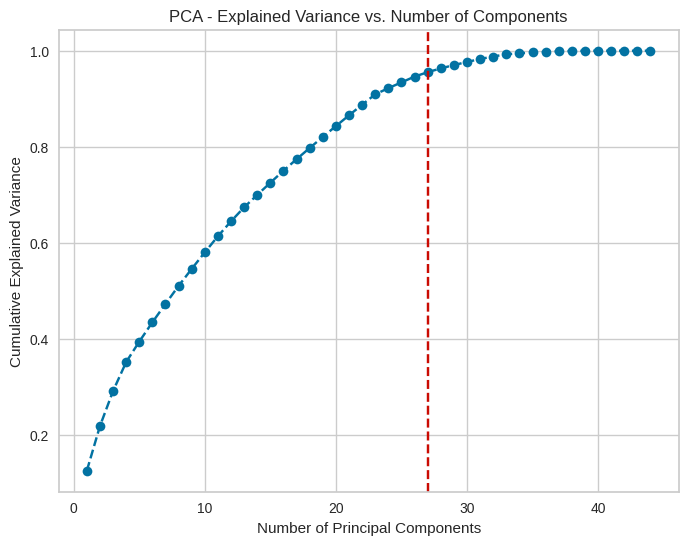

Optimal number of components to retain 95% variance: 27
Cumulative explained variance: 0.9553374781923195


<ipython-input-22-44d38feb22ae>:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



GMM Silhouette Score: 0.07856455068445058
GMM Calinski-Harabasz Index: 270.5794691684751
GMM Davies-Bouldin Index: 3.2257582938233766


<ipython-input-22-44d38feb22ae>:112: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Spectral Clustering Silhouette Score: 0.10256194166941565
Spectral Clustering Calinski-Harabasz Index: 321.1624012282253
Spectral Clustering Davies-Bouldin Index: 2.4641894792579655


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [22]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd

def clustering_pipeline_with_visualization_sphere(df, cols_to_drop, visualization_method='umap'):
    """
    Perform clustering on PCA-reduced data and visualize using t-SNE or UMAP.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        cols_to_drop (list): List of columns to drop from the DataFrame.
        visualization_method (str): Method for visualization ('umap' or 'tsne').

    Returns:
        pd.DataFrame: The original DataFrame with additional cluster columns.
    """
    # Drop unnecessary columns
    X = df.drop(columns=cols_to_drop)

    # Define ordinal mappings
    educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
    income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
    deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

    # Apply ordinal encoding
    X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
    X['Income'] = X['Income'].map(income_mapping)
    X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

    # Columns to apply one-hot encoding to
    categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                           'Previous_Cancellations', 'Required_Car_Parking']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

    # Apply one-hot encoding to categorical columns
    encoded_features = encoder.fit_transform(X[categorical_columns])

    # Convert encoded features to DataFrame with appropriate column names
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df = encoded_df.astype(int)

    # Reset indices of both DataFrames to ensure alignment
    X = X.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    # Concatenate encoded columns back to original DataFrame
    X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

    # Select only numerical columns
    numerical_df = X.select_dtypes(include=['number'])

    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_df)

    # Fit PCA
    pca = PCA()
    pca.fit(scaled_data)

    # Calculate cumulative explained variance ratio
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components that retain 95% of the variance
    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

    # Apply PCA with the selected number of components
    pca = PCA(n_components=optimal_components)
    pca_data = pca.fit_transform(scaled_data)

    # Plot the cumulative explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b', linestyle='--')
    plt.axvline(x=optimal_components, color='r', linestyle='--')
    plt.title('PCA - Explained Variance vs. Number of Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # Output the number of components selected and the variance explained
    print(f"Optimal number of components to retain 95% variance: {optimal_components}")
    print(f"Cumulative explained variance: {cumulative_variance[optimal_components - 1]}")

    # Gaussian Mixture Models (GMM)
    gmm = GaussianMixture(n_components=5, random_state=42)  # You can adjust the number of components
    gmm_labels = gmm.fit_predict(pca_data)
    df['cluster_gmm'] = gmm_labels
    X['cluster_gmm'] = gmm_labels

    # Calculate Silhouette Score for GMM
    gmm_silhouette = silhouette_score(pca_data, gmm_labels)
    gmm_calinski = calinski_harabasz_score(pca_data, gmm_labels)
    gmm_davies = davies_bouldin_score(pca_data, gmm_labels)

    print(f"GMM Silhouette Score: {gmm_silhouette}")
    print(f"GMM Calinski-Harabasz Index: {gmm_calinski}")
    print(f"GMM Davies-Bouldin Index: {gmm_davies}")

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)  # Adjust n_clusters
    spectral_labels = spectral.fit_predict(pca_data)
    df['cluster_spectral'] = spectral_labels
    X['cluster_spectral'] = spectral_labels


    # Calculate Silhouette Score for Spectral Clustering
    spectral_silhouette = silhouette_score(pca_data, spectral_labels)
    spectral_calinski = calinski_harabasz_score(pca_data, spectral_labels)
    spectral_davies = davies_bouldin_score(pca_data, spectral_labels)

    print(f"Spectral Clustering Silhouette Score: {spectral_silhouette}")
    print(f"Spectral Clustering Calinski-Harabasz Index: {spectral_calinski}")
    print(f"Spectral Clustering Davies-Bouldin Index: {spectral_davies}")

    # Apply t-SNE or UMAP for visualization
    if visualization_method == 'tsne':
        reducer = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
        reducer_name = 't-SNE'
    else:
        reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
        reducer_name = 'UMAP'

    reduced_data = reducer.fit_transform(pca_data)

    # Create a DataFrame for reduced components
    df_reduced = pd.DataFrame(reduced_data, columns=[f'{reducer_name}1', f'{reducer_name}2', f'{reducer_name}3'])
    df_reduced['cluster_gmm'] = gmm_labels
    df_reduced['cluster_spectral'] = spectral_labels

    # Create a 3D scatter plot of the reduced clusters (GMM)
    fig_gmm = px.scatter_3d(df_reduced,
                            x=f'{reducer_name}1',
                            y=f'{reducer_name}2',
                            z=f'{reducer_name}3',
                            color=df_reduced['cluster_gmm'].astype(str),
                            title=f"3D {reducer_name} Visualization: GMM",
                            labels={'cluster_gmm': 'Cluster'},
                            opacity=0.8)
    fig_gmm.show()

    # Create a 3D scatter plot of the reduced clusters (Spectral Clustering)
    fig_spectral = px.scatter_3d(df_reduced,
                                 x=f'{reducer_name}1',
                                 y=f'{reducer_name}2',
                                 z=f'{reducer_name}3',
                                 color=df_reduced['cluster_spectral'].astype(str),
                                 title=f"3D {reducer_name} Visualization: Spectral Clustering",
                                 labels={'cluster_spectral': 'Cluster'},
                                 opacity=0.8)
    fig_spectral.show()

    return df, X

# Example usage:
# df = pd.read_csv('your_data.csv')
# cols_to_drop = [
#     'Reservation_ID',
#     'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log',
#     'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
# ]
df_with_clusters, cancelled_set2 = clustering_pipeline_with_visualization_sphere(df_canceled, cols_to_drop, visualization_method='umap')

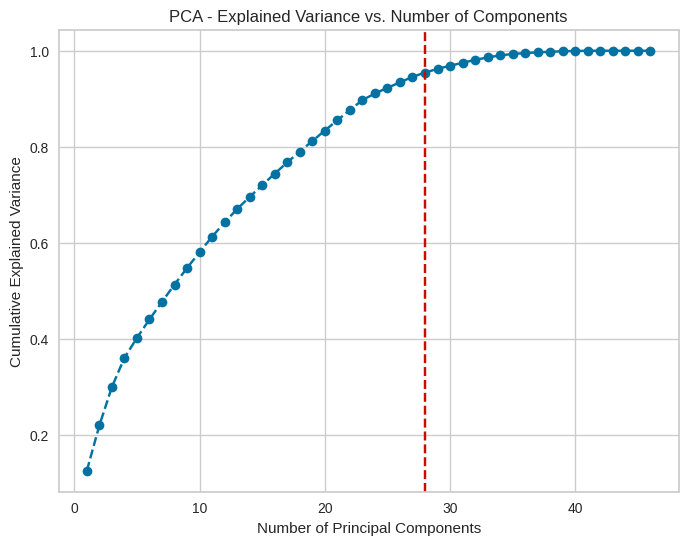

Optimal number of components to retain 95% variance: 28
Cumulative explained variance: 0.9545607113553152
Affinity Matrix (First 5x5):
[[1.00000000e+00 3.56449621e-02 3.73062523e-03 8.35491195e-03
  3.22909691e-03]
 [3.56449621e-02 1.00000000e+00 6.86209913e-04 4.25095725e-02
  1.98479391e-02]
 [3.73062523e-03 6.86209913e-04 1.00000000e+00 8.58044694e-05
  4.63035121e-05]
 [8.35491195e-03 4.25095725e-02 8.58044694e-05 1.00000000e+00
  1.48402168e-01]
 [3.22909691e-03 1.98479391e-02 4.63035121e-05 1.48402168e-01
  1.00000000e+00]]


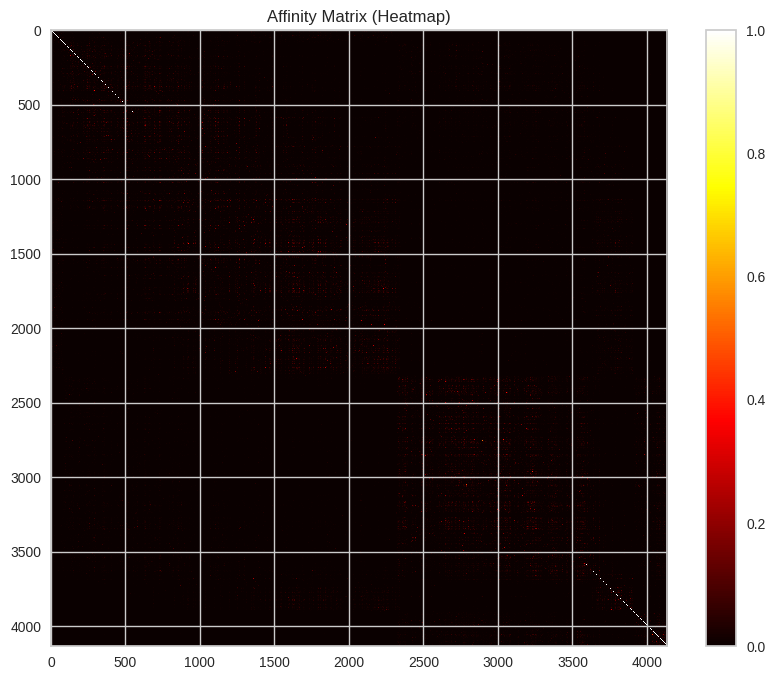

Graph Laplacian (First 5x5):
[[ 1.00000000e+00 -6.71206184e-03 -2.55947114e-03 -1.71717255e-03
  -5.89590665e-04]
 [-6.71206184e-03  1.00000000e+00 -3.78494765e-04 -7.02413862e-03
  -2.91352811e-03]
 [-2.55947114e-03 -3.78494765e-04  1.00000000e+00 -5.16567487e-05
  -2.47644422e-05]
 [-1.71717255e-03 -7.02413862e-03 -5.16567487e-05  1.00000000e+00
  -2.37770685e-02]
 [-5.89590665e-04 -2.91352811e-03 -2.47644422e-05 -2.37770685e-02
   1.00000000e+00]]
Eigenvalues (First 5):
[1.77635684e-15 1.69683915e-01 3.15877146e-01 3.71277742e-01
 4.40341050e-01]
Eigenvectors (First 5):
[[ 0.01031694  0.01596237  0.00334835  0.0032303   0.00388875]
 [ 0.01283265  0.01835335  0.00336832  0.00511179  0.00217654]
 [ 0.00352213  0.00297507 -0.00038689 -0.0100404  -0.00091305]
 ...
 [ 0.0076618  -0.00455233 -0.0087921   0.00227361  0.00385617]
 [ 0.00486013  0.00013313 -0.00290736 -0.01397594  0.01976705]
 [ 0.01038901 -0.00574136 -0.01291392  0.00172206  0.00264216]]


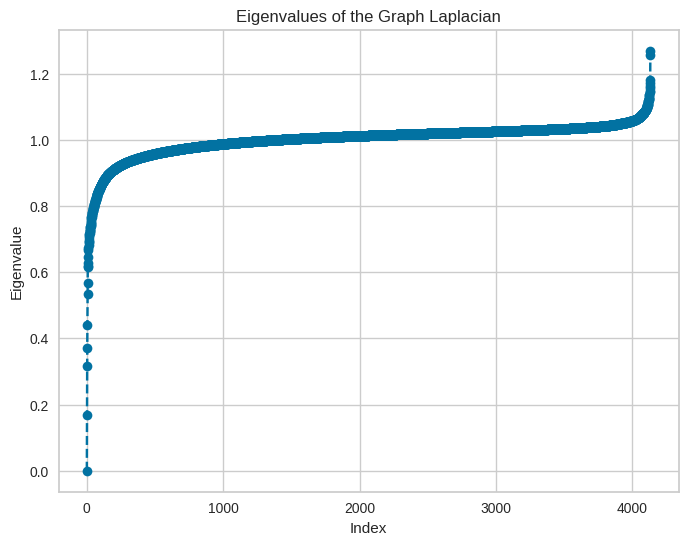

<ipython-input-27-4c7fd04fec01>:131: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Spectral Clustering Silhouette Score: 0.11772251331376911
Spectral Clustering Calinski-Harabasz Index: 356.5198671682383
Spectral Clustering Davies-Bouldin Index: 2.320967559217247


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Feature Influence Analysis:
Feature: Educational_Level, F-statistic: 0.20396005816484006, p-value: 0.9362960694749145
Feature: Income, F-statistic: 0.09279511848611438, p-value: 0.9847620646657719
Feature: Adults, F-statistic: 628.8355362868451, p-value: 0.0
Feature: Children, F-statistic: 53.996744799577435, p-value: 1.9953104902907112e-44
Feature: Babies, F-statistic: 0.5270514398196156, p-value: 0.7158700763137801
Feature: Deposit_type, F-statistic: 4575.312674603691, p-value: 0.0
Feature: Discount_Rate, F-statistic: 45.108127889188886, p-value: 3.919248408275313e-37
Feature: Room_Rate, F-statistic: 67.70512082443362, p-value: 1.4052615291632091e-55
Feature: Duration_checkin_checkout, F-statistic: 9.984476368942731, p-value: 4.862549908594722e-08
Feature: Booking_to_checkin_duration, F-statistic: 174.68881985661355, p-value: 1.9794433225165798e-138
Feature: No_of_Rooms, F-statistic: 1456.0945010741275, p-value: 0.0
Feature: Revenue, F-statistic: 277.2842844064381, p-value: 2.054659

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning:

Each of the input arrays is constant; the F statistic is not defined or infinite



In [27]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
import seaborn as sns
from sklearn.metrics.pairwise import rbf_kernel
from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh
# Example usage:
# df = pd.read_csv('your_data.csv')
cols_to_drop = [
    'Reservation_ID', 'Gender', 'Age',
    'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log',
    'No_of_ppl_without_babies', 'No_of_ppl_with_babies',
    'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
]
visualization_method='umap'

# Drop unnecessary columns
X = df_canceled.drop(columns=cols_to_drop)

# Define ordinal mappings
educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

# Apply ordinal encoding
X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
X['Income'] = X['Income'].map(income_mapping)
X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

# Columns to apply one-hot encoding to
categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                        'Previous_Cancellations', 'Required_Car_Parking']

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

# Apply one-hot encoding to categorical columns
encoded_features = encoder.fit_transform(X[categorical_columns])

# Convert encoded features to DataFrame with appropriate column names
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
encoded_df = encoded_df.astype(int)

# Reset indices of both DataFrames to ensure alignment
X = X.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Concatenate encoded columns back to original DataFrame
X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

# Select only numerical columns
numerical_df = X.select_dtypes(include=['number'])

# Standardize the numerical data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

# Fit PCA
pca = PCA()
pca.fit(scaled_data)

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that retain 95% of the variance
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

# Apply PCA with the selected number of components
pca = PCA(n_components=optimal_components)
pca_data = pca.fit_transform(scaled_data)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b', linestyle='--')
plt.axvline(x=optimal_components, color='r', linestyle='--')
plt.title('PCA - Explained Variance vs. Number of Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Output the number of components selected and the variance explained
print(f"Optimal number of components to retain 95% variance: {optimal_components}")
print(f"Cumulative explained variance: {cumulative_variance[optimal_components - 1]}")

# Step 1: Construct the Affinity Matrix
affinity_matrix = rbf_kernel(pca_data, gamma=0.1)  # You can adjust gamma
print("Affinity Matrix (First 5x5):")
print(affinity_matrix[:5, :5])

# Visualize the Affinity Matrix
plt.figure(figsize=(10, 8))
plt.imshow(affinity_matrix, cmap='hot', interpolation='nearest')
plt.title('Affinity Matrix (Heatmap)')
plt.colorbar()
plt.show()

# Step 2: Compute the Graph Laplacian
L = laplacian(affinity_matrix, normed=True)
print("Graph Laplacian (First 5x5):")
print(L[:5, :5])

# Step 3: Eigenvalue Decomposition
eigenvalues, eigenvectors = eigh(L)
print("Eigenvalues (First 5):")
print(eigenvalues[:5])
print("Eigenvectors (First 5):")
print(eigenvectors[:, :5])

# Plot the eigenvalues
plt.figure(figsize=(8, 6))
plt.plot(eigenvalues, marker='o', color='b', linestyle='--')
plt.title('Eigenvalues of the Graph Laplacian')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

# Step 4: Spectral Clustering
spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)  # Adjust n_clusters
spectral_labels = spectral.fit_predict(pca_data)
df_canceled['cluster_spectral'] = spectral_labels
X['cluster_spectral'] = spectral_labels

# Calculate Silhouette Score for Spectral Clustering
spectral_silhouette = silhouette_score(pca_data, spectral_labels)
spectral_calinski = calinski_harabasz_score(pca_data, spectral_labels)
spectral_davies = davies_bouldin_score(pca_data, spectral_labels)

print(f"Spectral Clustering Silhouette Score: {spectral_silhouette}")
print(f"Spectral Clustering Calinski-Harabasz Index: {spectral_calinski}")
print(f"Spectral Clustering Davies-Bouldin Index: {spectral_davies}")

# Apply t-SNE or UMAP for visualization
if visualization_method == 'tsne':
    reducer = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
    reducer_name = 't-SNE'
else:
    reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
    reducer_name = 'UMAP'

reduced_data = reducer.fit_transform(pca_data)

# Create a DataFrame for reduced components
df_reduced = pd.DataFrame(reduced_data, columns=[f'{reducer_name}1', f'{reducer_name}2', f'{reducer_name}3'])
df_reduced['cluster_spectral'] = spectral_labels

# Create a 3D scatter plot of the reduced clusters (Spectral Clustering)
fig_spectral = px.scatter_3d(df_reduced,
                              x=f'{reducer_name}1',
                              y=f'{reducer_name}2',
                              z=f'{reducer_name}3',
                              color=df_reduced['cluster_spectral'].astype(str),
                              title=f"3D {reducer_name} Visualization: Spectral Clustering",
                              labels={'cluster_spectral': 'Cluster'},
                              opacity=0.8)
fig_spectral.show()

# Feature Influence Analysis
print("\nFeature Influence Analysis:")
numerical_df['cluster_spectral'] = spectral_labels

# Perform ANOVA for each feature
for feature in numerical_df.columns[:-1]:  # Exclude the 'cluster_spectral' column
    groups = [numerical_df[feature][numerical_df['cluster_spectral'] == cluster] for cluster in numerical_df['cluster_spectral'].unique()]
    f_stat, p_value = f_oneway(*groups)
    print(f"Feature: {feature}, F-statistic: {f_stat}, p-value: {p_value}")






In [25]:
differences = np.diff(eigenvalues)  # Compute differences between consecutive eigenvalues
elbow_index = np.argmax(differences < 0.01)  # Find where the drop slows (adjust threshold as needed)

print(f"Optimal number of clusters: {elbow_index + 1}")

Optimal number of clusters: 11


In [30]:
with pd.option_context('display.max_rows', None):
    display(df_canceled.drop(columns=cols_to_drop).groupby('cluster_spectral').describe(include='all').T)

cluster_spectral                               0            1            2  \
Ethnicity                    count          1130          901          984   
                             unique            3            4            4   
                             top          Latino       Latino       Latino   
                             freq            429          356          380   
                             mean            NaN          NaN          NaN   
                             std             NaN          NaN          NaN   
                             min             NaN          NaN          NaN   
                             25%             NaN          NaN          NaN   
                             50%             NaN          NaN          NaN   
                             75%             NaN          NaN          NaN   
                             max             NaN          NaN          NaN   
Educational_Level            count          1130          901          984   
                             unique            4            4            4   
                             top         College      College      College   
                             freq            475          354          390   
                             mean            NaN          NaN          NaN   
                             std             NaN          NaN          NaN   
                             min             NaN          NaN          NaN   
                             25%             NaN          NaN          NaN   
                             50%             NaN          NaN          NaN   
                             75%             NaN          NaN          NaN   
                             max             NaN          NaN          NaN   
Income                       count          1130          901          984   
                             unique            4            4            4   
                             top       25K --50K  50K -- 100K         <25K   
                             freq            330          266          287   
                             mean            NaN          NaN          NaN   
                             std             NaN          NaN          NaN   
                             min             NaN          NaN          NaN   
                             25%             NaN          NaN          NaN   
                             50%             NaN          NaN          NaN   
                             75%             NaN          NaN          NaN   
                             max             NaN          NaN          NaN   
Country_region               count          1130          901          984   
                             unique            4            4            4   
                             top           South        South        South   
                             freq            462          340          410   
                             mean            NaN          NaN          NaN   
                             std             NaN          NaN          NaN   
                             min             NaN          NaN          NaN   
                             25%             NaN          NaN          NaN   
                             50%             NaN          NaN          NaN   
                             75%             NaN          NaN          NaN   
                             max             NaN          NaN          NaN   
Hotel_Type                   count          1130          901          984   
                             unique            2            3            3   
                             top      City Hotel   City Hotel   City Hotel   
                             freq            684          564          575   
                             mean            NaN          NaN          NaN   
                             std             NaN          NaN          NaN   
                      

In [32]:
# Define significant features
significant_features = [
    'Deposit_type', 'Room_Rate', 'Booking_to_checkin_duration', #'Hotel_Type_City Hotel', 'Hotel_Type_Resort',
    'No_of_Rooms', 'Revenue', 'Revenue_with_disc', 'Adults', 'Children'
]

with pd.option_context('display.max_rows', None):
    display(df_canceled.drop(columns=cols_to_drop).groupby('cluster_spectral')[significant_features].describe(include='all').T)



cluster_spectral                             0           1           2  \
Deposit_type                count         1130         901         984   
                            unique           2           3           3   
                            top     No Deposit  No Deposit  No Deposit   
                            freq           983         789         838   
                            mean           NaN         NaN         NaN   
                            std            NaN         NaN         NaN   
                            min            NaN         NaN         NaN   
                            25%            NaN         NaN         NaN   
                            50%            NaN         NaN         NaN   
                            75%            NaN         NaN         NaN   
                            max            NaN         NaN         NaN   
Room_Rate                   count       1130.0       901.0       984.0   
                            unique         NaN         NaN         NaN   
                            top            NaN         NaN         NaN   
                            freq           NaN         NaN         NaN   
                            mean    149.841746   149.17036  149.679023   
                            std      35.181319   33.593864   32.327725   
                            min     100.057988  100.157926  100.041732   
                            25%     121.494558   121.95758  123.363899   
                            50%     142.546287  146.787989  144.670265   
                            75%     173.456917  169.156402  171.597628   
                            max     249.884076  249.111649  249.162896   
Booking_to_checkin_duration count       1130.0       901.0       984.0   
                            unique         NaN         NaN         NaN   
                            top            NaN         NaN         NaN   
                            freq           NaN         NaN         NaN   
                            mean     78.884956  106.240844   146.50813   
                            std      57.175139   63.343286    52.41644   
                            min            0.0         0.0         2.0   
                            25%           30.0        52.0       109.0   
                            50%           70.0       106.0       157.0   
                            75%          120.0       160.0       191.0   
                            max          220.0       222.0       222.0   
No_of_Rooms                 count       1130.0       901.0       984.0   
                            unique         NaN         NaN         NaN   
                            top            NaN         NaN         NaN   
                            freq           NaN         NaN         NaN   
                            mean      1.007965    1.051054    1.006098   
                            std       0.088928    0.220231    0.077888   
                            min            1.0         1.0         1.0   
                            25%            1.0         1.0         1.0   
                            50%            1.0         1.0         1.0   
                            75%            1.0         1.0         1.0   
                            max            2.0         2.0         2.0   
Revenue                     count       1130.0       901.0       984.0   
                            unique         NaN         NaN         NaN   
                            top            NaN         NaN         NaN   
                            freq           NaN         NaN         NaN   
                            mean    279.978082  278.815621  276.718593   
                            std     168.429446  159.935913  164.376928   
                            min     100.057988  100.169834  100.231441   
                            25%     141.546402  149.154453  145.044464   
                            50%     225.919299  230.605133  225.115072   
    

In [29]:
df_canceled.drop(columns=cols_to_drop).info()

<class 'pandas.core.frame.DataFrame'>
Index: 4134 entries, 35 to 27494
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ethnicity                     4134 non-null   object 
 1   Educational_Level             4134 non-null   object 
 2   Income                        4134 non-null   object 
 3   Country_region                4134 non-null   object 
 4   Hotel_Type                    4134 non-null   object 
 5   Adults                        4134 non-null   int64  
 6   Children                      4134 non-null   int64  
 7   Babies                        4134 non-null   int64  
 8   Meal_Type                     4134 non-null   object 
 9   Visted_Previously             4134 non-null   object 
 10  Previous_Cancellations        4134 non-null   object 
 11  Deposit_type                  4134 non-null   object 
 12  Booking_channel               4134 non-null   object 
 13  Requir

## PCA

### all dataset

In [ ]:
df.info()

In [ ]:
# Columns to drop
cols_to_drop = [
    'Reservation_ID','Gender','Age',
    'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log',#'cluster',
    'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
]

# Dropping unnecessary columns
X = df.drop(columns=cols_to_drop)

# Checking the remaining columns
X.info()

In [ ]:
from sklearn.preprocessing import OneHotEncoder


X = df.drop(columns=cols_to_drop)

# Define ordinal mappings
educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

# Apply ordinal encoding
X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
X['Income'] = X['Income'].map(income_mapping)
X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

# Columns to apply one-hot encoding to
categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                       'Previous_Cancellations', 'Required_Car_Parking']

# Initialize OneHotEncoder
# Change 'sparse=False' to 'sparse_output=False'
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

# Apply one-hot encoding to categorical columns
encoded_features = encoder.fit_transform(X[categorical_columns])

# Convert encoded features to DataFrame with appropriate column names
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
encoded_df = encoded_df.astype(int)

# Concatenate encoded columns back to original DataFrame
X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

# Display the transformed DataFrame
# Display the transformed DataFrame
X.info()

In [ ]:
numerical_df = X.select_dtypes(include=['number'])
numerical_df.head()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Select only numerical columns

# Standardize the numerical data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

# Fit PCA
pca = PCA()
pca.fit(scaled_data)

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that retain 95% of the variance
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

# Apply PCA with the selected number of components
pca = PCA(n_components=optimal_components)
pca_data = pca.fit_transform(scaled_data)

# Plot the cumulative explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b', linestyle='--')
plt.axvline(x=optimal_components, color='r', linestyle='--')
plt.title('PCA - Explained Variance vs. Number of Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Output the number of components selected and the variance explained
print(f"Optimal number of components to retain 95% variance: {optimal_components}")
print(f"Cumulative explained variance: {cumulative_variance[optimal_components-1]}")


In [ ]:
import plotly.graph_objects as go

# Assuming pca_data is your transformed data and you are using the first three principal components

fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=pca_data[:, 0],  # First principal component
    y=pca_data[:, 1],  # Second principal component
    z=pca_data[:, 2],  # Third principal component
    mode='markers',
    marker=dict(color='blue', size=5, opacity=0.5)
))

fig.update_layout(
    title='3D Visualization of PCA (First Three Components)',
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    showlegend=False
)

fig.show()


In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model with a fixed random seed and n_init
km_model = KMeans(random_state=42, n_init=10)  # Set random_state and n_init

# Use KElbowVisualizer to find optimal K
visualizer = KElbowVisualizer(km_model, k=(2, 15))
visualizer.fit(pca_data)
visualizer.show()

# Get optimal K
optimal_k = visualizer.elbow_value_

# Refit KMeans with optimal K, random_state, and n_init
km_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
km_model.fit(pca_data)

# Add cluster labels to the original DataFrame
X['cluster'] = km_model.labels_

# Display the DataFrame with cluster labels
(X.head())

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_samples, silhouette_score
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import numpy as np

# # Assuming 'pca_data' is your PCA-transformed data with 95% variance retained
# # Make sure 'pca_data' contains the PCA-transformed data from your earlier steps

# range_n_clusters = [3, 4, 5, 6]

# for n_clusters in range_n_clusters:
#     # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.set_size_inches(18, 7)

#     # The 1st subplot is the silhouette plot
#     ax1.set_xlim([-0.1, 1])
#     ax1.set_ylim([0, len(pca_data) + (n_clusters + 1) * 10])

#     # Initialize the clusterer with n_clusters value and a random generator seed of 10
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
#     cluster_labels = clusterer.fit_predict(pca_data)

#     # The silhouette_score gives the average value for all the samples.
#     silhouette_avg = silhouette_score(pca_data, cluster_labels)
#     print(
#         "For n_clusters =",
#         n_clusters,
#         "The average silhouette_score is : {:.2f}".format(silhouette_avg),
#     )

#     # Compute the silhouette scores for each sample
#     sample_silhouette_values = silhouette_samples(pca_data, cluster_labels)

#     y_lower = 10
#     for i in range(n_clusters):
#         # Aggregate the silhouette scores for samples belonging to cluster i
#         ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#         ith_cluster_silhouette_values.sort()

#         size_cluster_i = ith_cluster_silhouette_values.shape[0]
#         y_upper = y_lower + size_cluster_i

#         color = cm.nipy_spectral(float(i) / n_clusters)
#         ax1.fill_betweenx(
#             np.arange(y_lower, y_upper),
#             0,
#             ith_cluster_silhouette_values,
#             facecolor=color,
#             edgecolor=color,
#             alpha=0.7,
#         )

#         ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#         y_lower = y_upper + 10  # 10 for the 0 samples

#     ax1.set_title("Silhouette plot for the various clusters.")
#     ax1.set_xlabel("Silhouette coefficient values")
#     ax1.set_ylabel("Cluster label")

#     ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

#     # 2nd Plot showing the actual clusters formed
#     colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(
#         pca_data[:, 0], pca_data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
#     )

#     # Labeling the clusters with their centers
#     centers = clusterer.cluster_centers_
#     ax2.scatter(
#         centers[:, 0],
#         centers[:, 1],
#         marker="o",
#         c="white",
#         alpha=1,
#         s=200,
#         edgecolor="k",
#     )

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

#     ax2.set_title("Visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

#     plt.suptitle(
#         f"Silhouette analysis for KMeans clustering with n_clusters = {n_clusters}",
#         fontsize=14,
#         fontweight="bold",
#     )

# plt.show()


In [ ]:
import plotly.express as px
from sklearn.cluster import KMeans



# Create a new DataFrame for visualization
df_pca = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
df_pca['cluster'] = km_model.labels_  # Assign cluster labels

# Create a 3D scatter plot of the PCA clusters
fig = px.scatter_3d(df_pca,
                    x='PC1',
                    y='PC2',
                    z='PC3',
                    color=df_pca['cluster'].astype(str),
                    title="3D PCA Clustering Visualization",
                    labels={'cluster': 'Cluster'},
                    opacity=0.8)

# Show the plot
fig.show()


In [ ]:
#pd.set_option('display.max_rows', None)
X.groupby(X['cluster']).describe(include='all').T

In [ ]:
# Columns to drop
cols_to_drop = [
    'Reservation_ID','Revenue_with_disc_log',
    'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Reservation_Status_numeric',
    #'Reservation_Status',  'is_canceled', 'is_no_show', 'is_check_out',
]

# Dropping unnecessary columns
dfc = df.drop(columns=cols_to_drop)

# Checking the remaining columns
dfc['cluster'] = km_model.labels_
dfc.groupby(dfc['cluster']).describe(include='all').T

### cancelled dataset

In [ ]:
# Columns to drop
cols_to_drop = [
    'Reservation_ID','Gender','Age',
    'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log',#'cluster',
    'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
]
df_canceled = df[df['is_canceled'] == 1]

In [ ]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def clustering_pipeline_pca(df, cols_to_drop):
    """
    Perform clustering on the given DataFrame using PCA, KMeans, DBSCAN, and Hierarchical Clustering.
    """
    # Drop unnecessary columns
    X = df.drop(columns=cols_to_drop)

    # Define ordinal mappings
    educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
    income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
    deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

    # Apply ordinal encoding
    X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
    X['Income'] = X['Income'].map(income_mapping)
    X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

    # Columns to apply one-hot encoding to
    categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                           'Previous_Cancellations', 'Required_Car_Parking']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

    # Apply one-hot encoding to categorical columns
    encoded_features = encoder.fit_transform(X[categorical_columns])

    # Convert encoded features to DataFrame with appropriate column names
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df = encoded_df.astype(int)

    # Reset indices of both DataFrames to ensure alignment
    X = X.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    # Concatenate encoded columns back to original DataFrame
    X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

    # Select only numerical columns
    numerical_df = X.select_dtypes(include=['number'])

    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_df)

    # Fit PCA
    pca = PCA()
    pca.fit(scaled_data)

    # Calculate cumulative explained variance ratio
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components that retain 95% of the variance
    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

    # Apply PCA with the selected number of components
    pca = PCA(n_components=optimal_components)
    pca_data = pca.fit_transform(scaled_data)

    # Plot the cumulative explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b', linestyle='--')
    plt.axvline(x=optimal_components, color='r', linestyle='--')
    plt.title('PCA - Explained Variance vs. Number of Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # Output the number of components selected and the variance explained
    print(f"Optimal number of components to retain 95% variance: {optimal_components}")
    print(f"Cumulative explained variance: {cumulative_variance[optimal_components - 1]}")

    # Use KElbowVisualizer to find optimal K
    km_model = KMeans(random_state=42, n_init=10)
    visualizer = KElbowVisualizer(km_model, k=(2, 15))
    visualizer.fit(pca_data)
    visualizer.show()

    # Get optimal K
    optimal_k = visualizer.elbow_value_

    # Refit KMeans with optimal K, random_state, and n_init
    km_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    km_model.fit(pca_data)

    # Add cluster labels to the original DataFrame
    df['cluster_kmeans'] = km_model.labels_
    X['cluster_kmeans'] = km_model.labels_

    # Calculate Silhouette Score for KMeans
    km_silhouette = silhouette_score(pca_data, df['cluster_kmeans'])
    km_calinski = calinski_harabasz_score(pca_data, df['cluster_kmeans'])
    km_davies = davies_bouldin_score(pca_data, df['cluster_kmeans'])

    print(f"KMeans Silhouette Score: {km_silhouette}")
    print(f"KMeans Calinski-Harabasz Index: {km_calinski}")
    print(f"KMeans Davies-Bouldin Index: {km_davies}")

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
    dbscan_labels = dbscan.fit_predict(pca_data)
    df['cluster_dbscan'] = dbscan_labels
    X['cluster_dbscan'] = dbscan_labels


    # Calculate Silhouette Score for DBSCAN
    if len(set(dbscan_labels)) > 1:  # DBSCAN may produce only one cluster or noise
        dbscan_silhouette = silhouette_score(pca_data, dbscan_labels)
        dbscan_calinski = calinski_harabasz_score(pca_data, dbscan_labels)
        dbscan_davies = davies_bouldin_score(pca_data, dbscan_labels)
    else:
        dbscan_silhouette, dbscan_calinski, dbscan_davies = None, None, None

    print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
    print(f"DBSCAN Calinski-Harabasz Index: {dbscan_calinski}")
    print(f"DBSCAN Davies-Bouldin Index: {dbscan_davies}")

    # Hierarchical Clustering
    agglo = AgglomerativeClustering(n_clusters=optimal_k)  # Use optimal_k from KMeans
    agglo_labels = agglo.fit_predict(pca_data)
    df['cluster_agglo'] = agglo_labels
    X['cluster_agglo'] = agglo_labels

    # Calculate Silhouette Score for Hierarchical Clustering
    agglo_silhouette = silhouette_score(pca_data, agglo_labels)
    agglo_calinski = calinski_harabasz_score(pca_data, agglo_labels)
    agglo_davies = davies_bouldin_score(pca_data, agglo_labels)

    print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette}")
    print(f"Agglomerative Clustering Calinski-Harabasz Index: {agglo_calinski}")
    print(f"Agglomerative Clustering Davies-Bouldin Index: {agglo_davies}")

    # Create a DataFrame for PCA components
    df_pca = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
    df_pca['cluster_kmeans'] = km_model.labels_
    df_pca['cluster_dbscan'] = dbscan_labels
    df_pca['cluster_agglo'] = agglo_labels

    # Create a 3D scatter plot of the PCA clusters (KMeans)
    fig_kmeans = px.scatter_3d(df_pca,
                               x='PC1',
                               y='PC2',
                               z='PC3',
                               color=df_pca['cluster_kmeans'].astype(str),
                               title="3D PCA Clustering Visualization: KMeans",
                               labels={'cluster_kmeans': 'Cluster'},
                               opacity=0.8)
    fig_kmeans.show()

    # Create a 3D scatter plot of the PCA clusters (DBSCAN)
    fig_dbscan = px.scatter_3d(df_pca,
                               x='PC1',
                               y='PC2',
                               z='PC3',
                               color=df_pca['cluster_dbscan'].astype(str),
                               title="3D PCA Clustering Visualization: DBSCAN",
                               labels={'cluster_dbscan': 'Cluster'},
                               opacity=0.8)
    fig_dbscan.show()

    # Create a 3D scatter plot of the PCA clusters (Hierarchical)
    fig_agglo = px.scatter_3d(df_pca,
                              x='PC1',
                              y='PC2',
                              z='PC3',
                              color=df_pca['cluster_agglo'].astype(str),
                              title="3D PCA Clustering Visualization: Hierarchical",
                              labels={'cluster_agglo': 'Cluster'},
                              opacity=0.8)
    fig_agglo.show()

    # Plot Dendrogram for Hierarchical Clustering
    plt.figure(figsize=(10, 7))
    linkage_matrix = linkage(pca_data, method='ward')
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

    return df, X

# Example usage:
# df = pd.read_csv('your_data.csv')
# cols_to_drop = [
#     'Reservation_ID',
#     'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log',
#     'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
# ]
df_with_clusters, cancelled_clusters = clustering_pipeline_pca(df_canceled, cols_to_drop)

In [ ]:
with pd.option_context('display.max_rows', None):
    display(cancelled_clusters.groupby('cluster').describe(include='all').T)

In [ ]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import plotly.express as px

def clustering_pipeline_pca(df, cols_to_drop):
    """
    Perform clustering on the given DataFrame using PCA, KMeans, DBSCAN, and Hierarchical Clustering.
    """
    # Drop unnecessary columns
    X = df.drop(columns=cols_to_drop)

    # Define ordinal mappings
    educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
    income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
    deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

    # Apply ordinal encoding
    X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
    X['Income'] = X['Income'].map(income_mapping)
    X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

    # Columns to apply one-hot encoding to
    categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                           'Previous_Cancellations', 'Required_Car_Parking']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

    # Apply one-hot encoding to categorical columns
    encoded_features = encoder.fit_transform(X[categorical_columns])

    # Convert encoded features to DataFrame with appropriate column names
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df = encoded_df.astype(int)

    # Reset indices of both DataFrames to ensure alignment
    X = X.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    # Concatenate encoded columns back to original DataFrame
    X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

    # Select only numerical columns
    numerical_df = X.select_dtypes(include=['number'])

    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_df)

    # Fit PCA
    pca = PCA()
    pca.fit(scaled_data)

    # Calculate cumulative explained variance ratio
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components that retain 95% of the variance
    optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

    # Apply PCA with the selected number of components
    pca = PCA(n_components=optimal_components)
    pca_data = pca.fit_transform(scaled_data)

    # Plot the cumulative explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='b', linestyle='--')
    plt.axvline(x=optimal_components, color='r', linestyle='--')
    plt.title('PCA - Explained Variance vs. Number of Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

    # Output the number of components selected and the variance explained
    print(f"Optimal number of components to retain 95% variance: {optimal_components}")
    print(f"Cumulative explained variance: {cumulative_variance[optimal_components - 1]}")

    # Use KElbowVisualizer to find optimal K
    km_model = KMeans(random_state=42, n_init=10)
    visualizer = KElbowVisualizer(km_model, k=(2, 15))
    visualizer.fit(pca_data)
    visualizer.show()

    # Get optimal K
    optimal_k = visualizer.elbow_value_

    # Refit KMeans with optimal K, random_state, and n_init
    km_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    km_model.fit(pca_data)

    # Add cluster labels to the original DataFrame
    df['cluster_kmeans'] = km_model.labels_
    X['cluster_kmeans'] = km_model.labels_

    # Calculate Silhouette Score for KMeans
    km_silhouette = silhouette_score(pca_data, df['cluster_kmeans'])
    km_calinski = calinski_harabasz_score(pca_data, df['cluster_kmeans'])
    km_davies = davies_bouldin_score(pca_data, df['cluster_kmeans'])

    print(f"KMeans Silhouette Score: {km_silhouette}")
    print(f"KMeans Calinski-Harabasz Index: {km_calinski}")
    print(f"KMeans Davies-Bouldin Index: {km_davies}")

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
    dbscan_labels = dbscan.fit_predict(pca_data)
    df['cluster_dbscan'] = dbscan_labels
    X['cluster_dbscan'] = dbscan_labels

    # Calculate Silhouette Score for DBSCAN
    if len(set(dbscan_labels)) > 1:  # DBSCAN may produce only one cluster or noise
        dbscan_silhouette = silhouette_score(pca_data, dbscan_labels)
        dbscan_calinski = calinski_harabasz_score(pca_data, dbscan_labels)
        dbscan_davies = davies_bouldin_score(pca_data, dbscan_labels)
    else:
        dbscan_silhouette, dbscan_calinski, dbscan_davies = None, None, None

    print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
    print(f"DBSCAN Calinski-Harabasz Index: {dbscan_calinski}")
    print(f"DBSCAN Davies-Bouldin Index: {dbscan_davies}")

    # Plot Dendrogram for Hierarchical Clustering
    plt.figure(figsize=(10, 7))
    linkage_matrix = linkage(pca_data, method='ward')  # Use 'ward' as the default linkage method
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

    # Ask the user to select the number of clusters based on the dendrogram
    n_clusters_agglo = int(input("Enter the number of clusters based on the dendrogram: "))

    # Hierarchical Clustering with user-selected number of clusters
    agglo = AgglomerativeClustering(n_clusters=n_clusters_agglo, linkage='ward')  # Use 'ward' linkage
    agglo_labels = agglo.fit_predict(pca_data)
    df['cluster_agglo'] = agglo_labels
    X['cluster_agglo'] = agglo_labels

    # Calculate Silhouette Score for Hierarchical Clustering
    agglo_silhouette = silhouette_score(pca_data, agglo_labels)
    agglo_calinski = calinski_harabasz_score(pca_data, agglo_labels)
    agglo_davies = davies_bouldin_score(pca_data, agglo_labels)

    print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette}")
    print(f"Agglomerative Clustering Calinski-Harabasz Index: {agglo_calinski}")
    print(f"Agglomerative Clustering Davies-Bouldin Index: {agglo_davies}")

    # Create a DataFrame for PCA components
    df_pca = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
    df_pca['cluster_kmeans'] = km_model.labels_
    df_pca['cluster_dbscan'] = dbscan_labels
    df_pca['cluster_agglo'] = agglo_labels

    # Create a 3D scatter plot of the PCA clusters (KMeans)
    fig_kmeans = px.scatter_3d(df_pca,
                               x='PC1',
                               y='PC2',
                               z='PC3',
                               color=df_pca['cluster_kmeans'].astype(str),
                               title="3D PCA Clustering Visualization: KMeans",
                               labels={'cluster_kmeans': 'Cluster'},
                               opacity=0.8)
    fig_kmeans.show()

    # Create a 3D scatter plot of the PCA clusters (DBSCAN)
    fig_dbscan = px.scatter_3d(df_pca,
                               x='PC1',
                               y='PC2',
                               z='PC3',
                               color=df_pca['cluster_dbscan'].astype(str),
                               title="3D PCA Clustering Visualization: DBSCAN",
                               labels={'cluster_dbscan': 'Cluster'},
                               opacity=0.8)
    fig_dbscan.show()

    # Create a 3D scatter plot of the PCA clusters (Hierarchical)
    fig_agglo = px.scatter_3d(df_pca,
                              x='PC1',
                              y='PC2',
                              z='PC3',
                              color=df_pca['cluster_agglo'].astype(str),
                              title="3D PCA Clustering Visualization: Hierarchical",
                              labels={'cluster_agglo': 'Cluster'},
                              opacity=0.8)
    fig_agglo.show()

    return df, X

# Example usage:
# df = pd.read_csv('your_data.csv')
# cols_to_drop = [
#     'Reservation_ID',
#     'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log',
#     'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
# ]
df_with_clusters, _ = clustering_pipeline_pca(df_canceled, cols_to_drop)

### no show and cancelled

In [ ]:
pd.reset_option('display.max_rows')
df_can_ns = df[(df['is_canceled'] == 1) | (df['is_no_show'] == 1)]


In [ ]:
df_ns_with_clusters,ns_clusters = clustering_pipeline(df_can_ns, cols_to_drop)

In [ ]:
ns_clusters.groupby(ns_clusters['cluster']).describe(include='all').T

## tsne


In [ ]:
from sklearn.manifold import TSNE

def clustering_pipeline_tsne(df, cols_to_drop):
    """
    Perform clustering on the given DataFrame using t-SNE and KMeans.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        cols_to_drop (list): List of columns to drop from the DataFrame.

    Returns:
        pd.DataFrame: The original DataFrame with an additional 'cluster' column.
    """
    # Drop unnecessary columns
    X = df.drop(columns=cols_to_drop)

    # Define ordinal mappings
    educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
    income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
    deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

    # Apply ordinal encoding
    X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
    X['Income'] = X['Income'].map(income_mapping)
    X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

    # Columns to apply one-hot encoding to
    categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                           'Previous_Cancellations', 'Required_Car_Parking']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

    # Apply one-hot encoding to categorical columns
    encoded_features = encoder.fit_transform(X[categorical_columns])

    # Convert encoded features to DataFrame with appropriate column names
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df = encoded_df.astype(int)

    # Reset indices of both DataFrames to ensure alignment
    X = X.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    # Concatenate encoded columns back to original DataFrame
    X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

    # Select only numerical columns
    numerical_df = X.select_dtypes(include=['number'])

    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_df)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)  # 3D for visualization
    tsne_data = tsne.fit_transform(scaled_data)

    # Use KElbowVisualizer to find optimal K
    km_model = KMeans(random_state=42, n_init=10)
    visualizer = KElbowVisualizer(km_model, k=(2, 15))
    visualizer.fit(tsne_data)
    visualizer.show()

    # Get optimal K
    optimal_k = visualizer.elbow_value_

    # Refit KMeans with optimal K, random_state, and n_init
    km_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    km_model.fit(tsne_data)

    # Add cluster labels to the original DataFrame
    df['cluster'] = km_model.labels_
    X['cluster'] = km_model.labels_

    # Calculate Silhouette Score
    score = silhouette_score(tsne_data, df['cluster'])
    print(f"Silhouette Score: {score}")

    # Create a DataFrame for t-SNE components
    df_tsne = pd.DataFrame(tsne_data, columns=['TSNE1', 'TSNE2', 'TSNE3'])

    # Add cluster labels to the t-SNE DataFrame
    df_tsne['cluster'] = km_model.labels_

    # Create a 3D scatter plot of the t-SNE clusters
    fig = px.scatter_3d(df_tsne,
                        x='TSNE1',
                        y='TSNE2',
                        z='TSNE3',
                        color=df_tsne['cluster'].astype(str),
                        title="3D t-SNE Clustering Visualization",
                        labels={'cluster': 'Cluster'},
                        opacity=0.8)

    # Show the plot
    fig.show()

    return df, X

# Example usage:
# df = pd.read_csv('your_data.csv')
# cols_to_drop = [
#     'Reservation_ID',
#     'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log',
#     'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
# ]
#df_with_tsneclusters, all_clustersts = clustering_pipeline(df, cols_to_drop)

In [ ]:
with pd.option_context('display.max_rows', None):
    display(all_clustersts.groupby('cluster').describe(include='all').T)

In [ ]:
from sklearn.manifold import TSNE

def clustering_pipeline_tsne(df, cols_to_drop):
    """
    Perform clustering on the given DataFrame using t-SNE and KMeans.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        cols_to_drop (list): List of columns to drop from the DataFrame.

    Returns:
        pd.DataFrame: The original DataFrame with an additional 'cluster' column.
    """
    # Drop unnecessary columns
    X = df.drop(columns=cols_to_drop)

    # Define ordinal mappings
    educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
    income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
    deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

    # Apply ordinal encoding
    X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
    X['Income'] = X['Income'].map(income_mapping)
    X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

    # Columns to apply one-hot encoding to
    categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                           'Previous_Cancellations', 'Required_Car_Parking']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

    # Apply one-hot encoding to categorical columns
    encoded_features = encoder.fit_transform(X[categorical_columns])

    # Convert encoded features to DataFrame with appropriate column names
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df = encoded_df.astype(int)

    # Reset indices of both DataFrames to ensure alignment
    X = X.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    # Concatenate encoded columns back to original DataFrame
    X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

    # Select only numerical columns
    numerical_df = X.select_dtypes(include=['number'])

    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_df)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)  # 3D for visualization
    tsne_data = tsne.fit_transform(scaled_data)

    # Use KElbowVisualizer to find optimal K
    km_model = KMeans(random_state=42, n_init=10)
    visualizer = KElbowVisualizer(km_model, k=(2, 15))
    visualizer.fit(tsne_data)
    visualizer.show()

    # Get optimal K
    optimal_k = visualizer.elbow_value_

    # Refit KMeans with optimal K, random_state, and n_init
    km_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    km_model.fit(tsne_data)

    # Add cluster labels to the original DataFrame
    df['cluster'] = km_model.labels_
    X['cluster'] = km_model.labels_

    # Calculate Silhouette Score
    score = silhouette_score(tsne_data, df['cluster'])
    print(f"Silhouette Score: {score}")

    # Create a DataFrame for t-SNE components
    df_tsne = pd.DataFrame(tsne_data, columns=['TSNE1', 'TSNE2', 'TSNE3'])

    # Add cluster labels to the t-SNE DataFrame
    df_tsne['cluster'] = km_model.labels_

    # Create a 3D scatter plot of the t-SNE clusters
    fig = px.scatter_3d(df_tsne,
                        x='TSNE1',
                        y='TSNE2',
                        z='TSNE3',
                        color=df_tsne['cluster'].astype(str),
                        title="3D t-SNE Clustering Visualization",
                        labels={'cluster': 'Cluster'},
                        opacity=0.8)

    # Show the plot
    fig.show()

    return df, X

# Example usage:
# df = pd.read_csv('your_data.csv')
# cols_to_drop = [
#     'Reservation_ID',
#     'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log',
#     'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
# ]
dfcan_with_tsneclusters, canceled_clustersts = clustering_pipeline_tsne(df_canceled, cols_to_drop)

In [ ]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

def clustering_pipeline_tsne(df, cols_to_drop):
    """
    Perform clustering on the given DataFrame using t-SNE and KMeans.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        cols_to_drop (list): List of columns to drop from the DataFrame.

    Returns:
        pd.DataFrame: The original DataFrame with an additional 'cluster' column.
    """
    # Drop unnecessary columns
    X = df.drop(columns=cols_to_drop)

    # Define ordinal mappings
    educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
    income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
    deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

    # Apply ordinal encoding
    X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
    X['Income'] = X['Income'].map(income_mapping)
    X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

    # Columns to apply one-hot encoding to
    categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                           'Previous_Cancellations', 'Required_Car_Parking']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

    # Apply one-hot encoding to categorical columns
    encoded_features = encoder.fit_transform(X[categorical_columns])

    # Convert encoded features to DataFrame with appropriate column names
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df = encoded_df.astype(int)

    # Reset indices of both DataFrames to ensure alignment
    X = X.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    # Concatenate encoded columns back to original DataFrame
    X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

    # Select only numerical columns
    numerical_df = X.select_dtypes(include=['number'])

    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_df)

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)  # 3D for visualization
    pca_data = tsne.fit_transform(scaled_data)



    # Use KElbowVisualizer to find optimal K
    km_model = KMeans(random_state=42, n_init=10)
    visualizer = KElbowVisualizer(km_model, k=(2, 15))
    visualizer.fit(pca_data)
    visualizer.show()

    # Get optimal K
    optimal_k = visualizer.elbow_value_

    # Refit KMeans with optimal K, random_state, and n_init
    km_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    km_model.fit(pca_data)

    # Add cluster labels to the original DataFrame
    df['cluster_kmeans'] = km_model.labels_
    X['cluster_kmeans'] = km_model.labels_

    # Calculate Silhouette Score for KMeans
    km_silhouette = silhouette_score(pca_data, df['cluster_kmeans'])
    km_calinski = calinski_harabasz_score(pca_data, df['cluster_kmeans'])
    km_davies = davies_bouldin_score(pca_data, df['cluster_kmeans'])

    print(f"KMeans Silhouette Score: {km_silhouette}")
    print(f"KMeans Calinski-Harabasz Index: {km_calinski}")
    print(f"KMeans Davies-Bouldin Index: {km_davies}")

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
    dbscan_labels = dbscan.fit_predict(pca_data)
    df['cluster_dbscan'] = dbscan_labels

    # Calculate Silhouette Score for DBSCAN
    if len(set(dbscan_labels)) > 1:  # DBSCAN may produce only one cluster or noise
        dbscan_silhouette = silhouette_score(pca_data, dbscan_labels)
        dbscan_calinski = calinski_harabasz_score(pca_data, dbscan_labels)
        dbscan_davies = davies_bouldin_score(pca_data, dbscan_labels)
    else:
        dbscan_silhouette, dbscan_calinski, dbscan_davies = None, None, None

    print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")
    print(f"DBSCAN Calinski-Harabasz Index: {dbscan_calinski}")
    print(f"DBSCAN Davies-Bouldin Index: {dbscan_davies}")

    # Hierarchical Clustering
    agglo = AgglomerativeClustering(n_clusters=optimal_k)  # Use optimal_k from KMeans
    agglo_labels = agglo.fit_predict(pca_data)
    df['cluster_agglo'] = agglo_labels

    # Calculate Silhouette Score for Hierarchical Clustering
    agglo_silhouette = silhouette_score(pca_data, agglo_labels)
    agglo_calinski = calinski_harabasz_score(pca_data, agglo_labels)
    agglo_davies = davies_bouldin_score(pca_data, agglo_labels)

    print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette}")
    print(f"Agglomerative Clustering Calinski-Harabasz Index: {agglo_calinski}")
    print(f"Agglomerative Clustering Davies-Bouldin Index: {agglo_davies}")

    # Create a DataFrame for PCA components
    df_pca = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
    df_pca['cluster_kmeans'] = km_model.labels_
    df_pca['cluster_dbscan'] = dbscan_labels
    df_pca['cluster_agglo'] = agglo_labels

    # Create a 3D scatter plot of the PCA clusters (KMeans)
    fig_kmeans = px.scatter_3d(df_pca,
                               x='PC1',
                               y='PC2',
                               z='PC3',
                               color=df_pca['cluster_kmeans'].astype(str),
                               title="3D PCA Clustering Visualization: KMeans",
                               labels={'cluster_kmeans': 'Cluster'},
                               opacity=0.8)
    fig_kmeans.show()

    # Create a 3D scatter plot of the PCA clusters (DBSCAN)
    fig_dbscan = px.scatter_3d(df_pca,
                               x='PC1',
                               y='PC2',
                               z='PC3',
                               color=df_pca['cluster_dbscan'].astype(str),
                               title="3D PCA Clustering Visualization: DBSCAN",
                               labels={'cluster_dbscan': 'Cluster'},
                               opacity=0.8)
    fig_dbscan.show()

    # Create a 3D scatter plot of the PCA clusters (Hierarchical)
    fig_agglo = px.scatter_3d(df_pca,
                              x='PC1',
                              y='PC2',
                              z='PC3',
                              color=df_pca['cluster_agglo'].astype(str),
                              title="3D PCA Clustering Visualization: Hierarchical",
                              labels={'cluster_agglo': 'Cluster'},
                              opacity=0.8)
    fig_agglo.show()

    # Plot Dendrogram for Hierarchical Clustering
    plt.figure(figsize=(10, 7))
    linkage_matrix = linkage(pca_data, method='ward')
    dendrogram(linkage_matrix, truncate_mode='level', p=5)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()

    return df, X

# Example usage:
# df = pd.read_csv('your_data.csv')
# cols_to_drop = [
#     'Reservation_ID',
#     'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log',
#     'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
# ]
df_with_clusters, _ = clustering_pipeline_tsne(df_canceled, cols_to_drop)

## UMAP

In [ ]:
from umap import UMAP
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import plotly.express as px

def clustering_pipeline_umap(df, cols_to_drop):
    """
    Perform clustering on the given DataFrame using UMAP and DBSCAN/Hierarchical Clustering.
    """
    # Drop unnecessary columns
    X = df.drop(columns=cols_to_drop)

    # Define ordinal mappings
    educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
    income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
    deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

    # Apply ordinal encoding
    X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
    X['Income'] = X['Income'].map(income_mapping)
    X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

    # Columns to apply one-hot encoding to
    categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                           'Previous_Cancellations', 'Required_Car_Parking']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

    # Apply one-hot encoding to categorical columns
    encoded_features = encoder.fit_transform(X[categorical_columns])

    # Convert encoded features to DataFrame with appropriate column names
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df = encoded_df.astype(int)

    # Reset indices of both DataFrames to ensure alignment
    X = X.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    # Concatenate encoded columns back to original DataFrame
    X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

    # Select only numerical columns
    numerical_df = X.select_dtypes(include=['number'])

    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_df)

    # Apply UMAP for dimensionality reduction
    umap = UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)  # 3D for visualization
    umap_data = umap.fit_transform(scaled_data)

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
    dbscan_labels = dbscan.fit_predict(scaled_data)
    df['cluster_dbscan'] = dbscan_labels

    # Hierarchical Clustering (Agglomerative)
    agglo = AgglomerativeClustering(n_clusters=5)  # Adjust n_clusters as needed
    agglo_labels = agglo.fit_predict(scaled_data)
    df['cluster_hierarchical'] = agglo_labels

    # Calculate Silhouette Scores
    dbscan_score = silhouette_score(scaled_data, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
    agglo_score = silhouette_score(scaled_data, agglo_labels) if len(set(agglo_labels)) > 1 else None

    print(f"DBSCAN Silhouette Score: {dbscan_score}")
    print(f"Agglomerative Clustering Silhouette Score: {agglo_score}")

    # Create a DataFrame for UMAP components
    df_umap = pd.DataFrame(umap_data, columns=['UMAP1', 'UMAP2', 'UMAP3'])
    df_umap['cluster_dbscan'] = dbscan_labels
    df_umap['cluster_hierarchical'] = agglo_labels

    # Visualize DBSCAN Clusters
    fig_dbscan = px.scatter_3d(df_umap,
                               x='UMAP1',
                               y='UMAP2',
                               z='UMAP3',
                               color=df_umap['cluster_dbscan'].astype(str),
                               title="3D UMAP Visualization: DBSCAN Clusters",
                               labels={'cluster_dbscan': 'Cluster'},
                               opacity=0.8)
    fig_dbscan.show()

    # Visualize Hierarchical Clusters
    fig_agglo = px.scatter_3d(df_umap,
                              x='UMAP1',
                              y='UMAP2',
                              z='UMAP3',
                              color=df_umap['cluster_hierarchical'].astype(str),
                              title="3D UMAP Visualization: Hierarchical Clusters",
                              labels={'cluster_hierarchical': 'Cluster'},
                              opacity=0.8)
    fig_agglo.show()

    return df, X

df_canc_umap, umap_clusters = clustering_pipeline_umap(df, cols_to_drop)

In [ ]:
from sklearn.cluster import KMeans  # Import KMeans

def clustering_pipeline_umap(df, cols_to_drop):
    """
    Perform clustering on the given DataFrame using UMAP, DBSCAN, Hierarchical Clustering, and KMeans.
    """
    # Drop unnecessary columns
    X = df.drop(columns=cols_to_drop)

    # Define ordinal mappings
    educational_level_mapping = {'Mid-School': 0, 'High-School': 1, 'College': 2, 'Grad': 3}
    income_mapping = {'<25K': 0, '25K --50K': 1, '50K -- 100K': 2, '>100K': 3}
    deposit_mapping = {'No Deposit': 0, 'Refundable': 1, 'Non-Refundable': 2}

    # Apply ordinal encoding
    X['Educational_Level'] = X['Educational_Level'].map(educational_level_mapping)
    X['Income'] = X['Income'].map(income_mapping)
    X['Deposit_type'] = X['Deposit_type'].map(deposit_mapping)

    # Columns to apply one-hot encoding to
    categorical_columns = ['Country_region', 'Hotel_Type', 'Meal_Type', 'Booking_channel',
                           'Previous_Cancellations', 'Required_Car_Parking']

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop first to avoid dummy variable trap

    # Apply one-hot encoding to categorical columns
    encoded_features = encoder.fit_transform(X[categorical_columns])

    # Convert encoded features to DataFrame with appropriate column names
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df = encoded_df.astype(int)

    # Reset indices of both DataFrames to ensure alignment
    X = X.reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    # Concatenate encoded columns back to original DataFrame
    X = pd.concat([X.drop(columns=categorical_columns), encoded_df], axis=1)

    # Select only numerical columns
    numerical_df = X.select_dtypes(include=['number'])

    # Standardize the numerical data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_df)

    # Apply UMAP for dimensionality reduction
    umap = UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)  # 3D for visualization
    umap_data = umap.fit_transform(scaled_data)

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed
    dbscan_labels = dbscan.fit_predict(scaled_data)
    df['cluster_dbscan'] = dbscan_labels

    # Hierarchical Clustering (Agglomerative)
    agglo = AgglomerativeClustering(n_clusters=5)  # Adjust n_clusters as needed
    agglo_labels = agglo.fit_predict(scaled_data)
    df['cluster_hierarchical'] = agglo_labels

    # KMeans Clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)  # Adjust n_clusters as needed
    kmeans_labels = kmeans.fit_predict(scaled_data)
    df['cluster_kmeans'] = kmeans_labels

    # Calculate Silhouette Scores
    dbscan_score = silhouette_score(scaled_data, dbscan_labels) if len(set(dbscan_labels)) > 1 else None
    agglo_score = silhouette_score(scaled_data, agglo_labels) if len(set(agglo_labels)) > 1 else None
    kmeans_score = silhouette_score(scaled_data, kmeans_labels) if len(set(kmeans_labels)) > 1 else None

    print(f"DBSCAN Silhouette Score: {dbscan_score}")
    print(f"Agglomerative Clustering Silhouette Score: {agglo_score}")
    print(f"KMeans Silhouette Score: {kmeans_score}")

    # Create a DataFrame for UMAP components
    df_umap = pd.DataFrame(umap_data, columns=['UMAP1', 'UMAP2', 'UMAP3'])
    df_umap['cluster_dbscan'] = dbscan_labels
    df_umap['cluster_hierarchical'] = agglo_labels
    df_umap['cluster_kmeans'] = kmeans_labels

    # Visualize DBSCAN Clusters
    fig_dbscan = px.scatter_3d(df_umap,
                               x='UMAP1',
                               y='UMAP2',
                               z='UMAP3',
                               color=df_umap['cluster_dbscan'].astype(str),
                               title="3D UMAP Visualization: DBSCAN Clusters",
                               labels={'cluster_dbscan': 'Cluster'},
                               opacity=0.8)
    fig_dbscan.show()

    # Visualize Hierarchical Clusters
    fig_agglo = px.scatter_3d(df_umap,
                              x='UMAP1',
                              y='UMAP2',
                              z='UMAP3',
                              color=df_umap['cluster_hierarchical'].astype(str),
                              title="3D UMAP Visualization: Hierarchical Clusters",
                              labels={'cluster_hierarchical': 'Cluster'},
                              opacity=0.8)
    fig_agglo.show()

    # Visualize KMeans Clusters
    fig_kmeans = px.scatter_3d(df_umap,
                               x='UMAP1',
                               y='UMAP2',
                               z='UMAP3',
                               color=df_umap['cluster_kmeans'].astype(str),
                               title="3D UMAP Visualization: KMeans Clusters",
                               labels={'cluster_kmeans': 'Cluster'},
                               opacity=0.8)
    fig_kmeans.show()

    return df, X

# Example usage:
# df = pd.read_csv('your_data.csv')
# cols_to_drop = [
#     'Reservation_ID',
#     'Expected_checkin', 'Expected_checkout', 'Booking_date', 'Revenue_with_disc_log',
#     'Reservation_Status', 'Reservation_Status_numeric', 'is_canceled', 'is_no_show', 'is_check_out',
# ]
df_canc_umap, umap_clusters = clustering_pipeline_umap(df, cols_to_drop)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = X.copy()

# Select relevant features
numerical_features = [
    'Age', 'Adults', 'Children', 'Babies', 'Discount_Rate', 'Room_Rate',
    'Duration_checkin_checkout', 'Booking_to_checkin_duration',
    'No_of_ppl_without_babies', 'No_of_ppl_with_babies', 'No_of_Rooms',
    'Revenue', 'Revenue_with_disc', 'stays_in_weekend', 'stays_in_week'
]

categorical_features = [
    'Gender', 'Ethnicity', 'Educational_Level', 'Income', 'Country_region',
    'Hotel_Type', 'Meal_Type', 'Visted_Previously', 'Previous_Cancellations',
    'Deposit_type', 'Booking_channel', 'Required_Car_Parking', 'Use_Promotion'
]

# Create a new DataFrame with selected features
clustering_data = data[numerical_features + categorical_features]

# Standardize numerical features
scaler = StandardScaler()
clustering_data[numerical_features] = scaler.fit_transform(clustering_data[numerical_features])

# Ensure categorical features are of type 'object' (required by K-Prototypes)
clustering_data[categorical_features] = clustering_data[categorical_features].astype('object')

In [ ]:
clustering_data

In [ ]:
famd_data

In [ ]:
famd.eigenvalues_summary

In [ ]:
!pip install altair vega_datasets
import altair as alt
alt.data_transformers.enable('vegafusion')
famd.plot(
    X,
    x_component=0,
    y_component=1
)